In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

<a id="intro"></a>

## Overview and data description
The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data 14 features for homes from various suburbs in Boston, Massachusetts.

### Data description
The following describes the dataset columns:
- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per 10,000 dollars
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - percent lower status of the population
- MEDV - Median value of owner-occupied homes in 1000's of dollars

In [2]:
# Import 2007-2016 Homelessness Data
homeless2 = pd.read_csv("Data/2007-2016-Homelessness-USA.csv")

In [3]:
# Import Boston Housing Data
data = pd.read_csv('Data/boston.csv')
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = data[column_names]

## Exploratory Data Analysis -- 2007-2016 Homelessness Data

In [4]:
# First 5 rows
homeless2.head()

,Year,State,CoC Number,CoC Name,Measures,Count
0,1/1/2007,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,224
1,1/1/2007,AK,AK-500,Anchorage CoC,Homeless Individuals,696
2,1/1/2007,AK,AK-500,Anchorage CoC,Homeless People in Families,278
3,1/1/2007,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,187
4,1/1/2007,AK,AK-500,Anchorage CoC,Sheltered Homeless,842


In [5]:
# Check to see data types and missing values
homeless2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86529 entries, 0 to 86528
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        86529 non-null  object
 1   State       86529 non-null  object
 2   CoC Number  86529 non-null  object
 3   CoC Name    86529 non-null  object
 4   Measures    86529 non-null  object
 5   Count       86529 non-null  object
dtypes: object(6)
memory usage: 4.0+ MB


In [6]:
# Convert 'Year' and 'Count' to more appropriate data types.
homeless2['Year'] = pd.to_datetime(homeless2['Year'])
homeless2['Year'] = homeless2['Year'].dt.year
homeless2['Count'] = homeless2['Count'].str.replace(',','').astype(int)

In [7]:
# Check basic statistics of the 'Count' variable
homeless2.describe()

,Year,Count
count,86529.000000,86529.000000
mean,2012.785806,332.286748
std,2.799828,1492.614929
min,2007.000000,0.000000
25%,2011.000000,7.000000
50%,2013.000000,52.000000
75%,2015.000000,235.000000
max,2016.000000,75323.000000


In [8]:
# Check to see how many unique values for each categorical variable
homeless2.nunique()

Year            10
State           54
CoC Number     414
CoC Name       414
Measures        42
Count         3608
dtype: int64

In [9]:
# Investigate 'Measures' further
homeless2.Measures.unique()

array(['Chronically Homeless Individuals', 'Homeless Individuals',
       'Homeless People in Families',
       'Sheltered Chronically Homeless Individuals', 'Sheltered Homeless',
       'Sheltered Homeless Individuals',
       'Sheltered Homeless People in Families', 'Total Homeless',
       'Unsheltered Chronically Homeless Individuals',
       'Unsheltered Homeless', 'Unsheltered Homeless Individuals',
       'Unsheltered Homeless People in Families', 'Chronically Homeless',
       'Chronically Homeless People in Families', 'Homeless Veterans',
       'Sheltered Chronically Homeless',
       'Sheltered Chronically Homeless People in Families',
       'Sheltered Homeless Veterans', 'Unsheltered Chronically Homeless',
       'Unsheltered Chronically Homeless People in Families',
       'Unsheltered Homeless Veterans', 'Children of Parenting Youth',
       'Homeless Unaccompanied Children (Under 18)',
       'Homeless Unaccompanied Young Adults (Age 18-24)',
       'Homeless Unaccompan

Eliminate all rows except 'Total Homeless' since these extra categories are beyond scope at this point.

In [10]:
homeless2_total = homeless2[homeless2['Measures'] == 'Total Homeless']

Group by year and state, and take sum.

Note: assumption here is that sum represents the total for each state, but this might not be true depending on how things are reported. If we decided to zero in on one particular region or city then the full set of data needs to be reexamined. The data is reported by a regional Continuum of Care (CoC) and its not clear whether the sum of each is the total for each state. It may be that we need to take the max() rather than the sum.

In [11]:
homeless2_sum = homeless2_total.groupby(['Year', 'State'])[['Count']].sum()
homeless2_sum.reset_index(inplace=True)
homeless2_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    540 non-null    int64 
 1   State   540 non-null    object
 2   Count   540 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 12.8+ KB


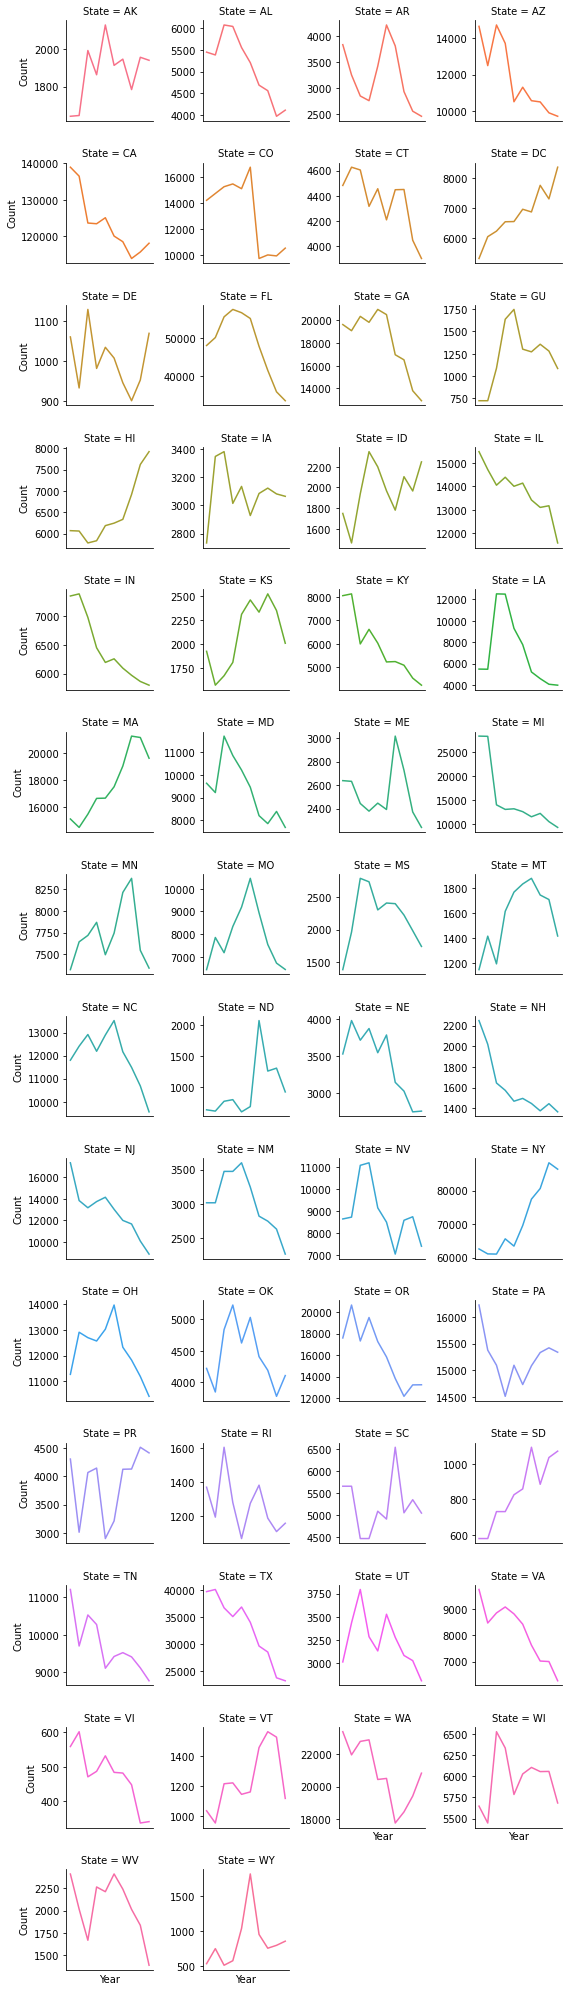

In [12]:
# Plot each state by year
g = sns.FacetGrid(homeless2_sum,col='State',hue='State',col_wrap=4,height=2,sharey=False)
g.map(sns.lineplot, 'Year', 'Count')
g.set(xticks=[])

In [13]:
# Find state with most homeless each year
max_list = homeless2_sum.groupby('Year')['Count'].max().tolist()
max_homeless2 = homeless2_sum[homeless2_sum['Count'].isin(max_list)]
max_homeless2

,Year,State,Count
4,2007,CA,138986
58,2008,CA,136531
112,2009,CA,123678
166,2010,CA,123480
220,2011,CA,125128
274,2012,CA,120098
328,2013,CA,118552
382,2014,CA,113952
436,2015,CA,115738
490,2016,CA,118142


In [14]:
# Find state with the least homeless people each year
min_list = homeless2_sum.groupby('Year')['Count'].min().tolist()
years = homeless2.Year.unique()
min_homeless2 = pd.DataFrame()
for i in range(len(min_list)):
    min_homeless2 = min_homeless2.append(homeless2_sum[(homeless2_sum['Year']==years[i])&(homeless2_sum['Count']==min_list[i])])
min_homeless2

,Year,State,Count
53,2007,WY,537
97,2008,SD,579
156,2009,VI,471
210,2010,VI,487
264,2011,VI,532
318,2012,VI,484
372,2013,VI,482
426,2014,VI,448
480,2015,VI,337
534,2016,VI,341


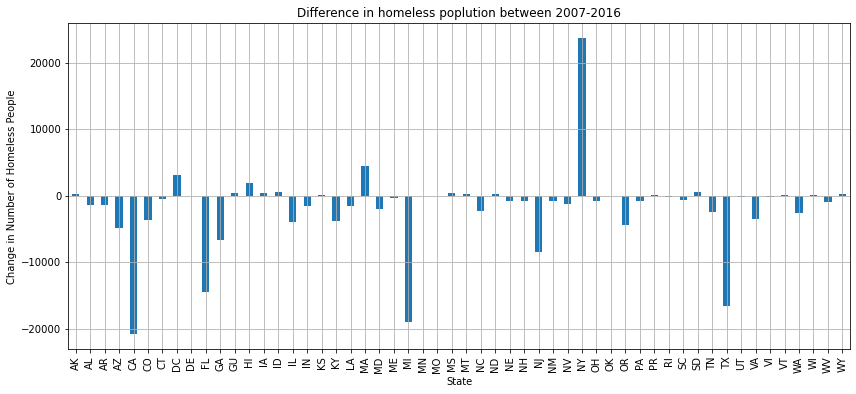

In [15]:
# Look at the difference in homeless for the decade
diff_homeless2 = homeless2_sum[(homeless2_sum['Year']==2016) | (homeless2_sum['Year']==2007)]
diff = diff_homeless2.groupby('State')[['Count']].diff().fillna(0)
diff.columns=['Difference']
diff_homeless2 = diff.join(diff_homeless2).groupby('State')['Difference'].sum()
diff_homeless2.plot.bar(figsize=(14,6))
plt.title('Difference in homeless poplution between 2007-2016')
plt.ylabel('Change in Number of Homeless People')
plt.grid(visible=True)
plt.show()

### New York Homelessness Trend

In [16]:
homelessNY = homeless2[homeless2['CoC Number'] == "NY-600"]
homelessNY.head(3)

,Year,State,CoC Number,CoC Name,Measures,Count
3444,2007,NY,NY-600,New York City CoC,Chronically Homeless Individuals,5233
3445,2007,NY,NY-600,New York City CoC,Homeless Individuals,21357
3446,2007,NY,NY-600,New York City CoC,Homeless People in Families,29015


In [17]:
homelessNY['Years from 2007'] = homelessNY['Year'] - 2007

In [18]:
homelessNY = homelessNY.groupby(['Year', 'Years from 2007']).sum().reset_index()

In [19]:
homelessNY.head(3)

,Year,Years from 2007,Count
0,2007,0,211954
1,2008,1,208814
2,2009,2,203578


In [20]:
x_ny = homelessNY[['Years from 2007']]
y_ny = homelessNY['Count']

lin_model = LinearRegression()
lin_model.fit(x_ny, y_ny) 

print(f'Linear Model Intercept: {lin_model.intercept_:.4f}')
print(f'Linear Model Slope: {lin_model.coef_[0]:.4f}')

Linear Model Intercept: 182513.0545
Linear Model Slope: 16687.1879


In [21]:
# Predict on homelessness data in NYC
y_nyc_pred = lin_model.predict(x_ny)

### Los Angeles Homelessness Trend

In [22]:
homelessLA = homeless2[homeless2['CoC Number'] == "CA-600"]
homelessLA.head(3)

,Year,State,CoC Number,CoC Name,Measures,Count
588,2007,CA,CA-600,Los Angeles City & County CoC,Chronically Homeless Individuals,19031
589,2007,CA,CA-600,Los Angeles City & County CoC,Homeless Individuals,44185
590,2007,CA,CA-600,Los Angeles City & County CoC,Homeless People in Families,3677


In [23]:
homelessLA['Years from 2007'] = homelessLA['Year'] - 2007

In [24]:
homelessLA = homelessLA.groupby(['Year', 'Years from 2007']).sum().reset_index()

In [25]:
homelessLA.head()

,Year,Years from 2007,Count
0,2007,0,229510
1,2008,1,229510
2,2009,2,148294
3,2010,3,148294
4,2011,4,189610


In [26]:
x_LA = homelessLA[['Years from 2007']]
y_LA = homelessLA['Count']

lin_model = LinearRegression()
lin_model.fit(x_LA, y_LA) 

print(f'Linear Model Intercept: {lin_model.intercept_:.4f}')
print(f'Linear Model Slope: {lin_model.coef_[0]:.4f}')

Linear Model Intercept: 183066.1091
Linear Model Slope: 3039.4424


In [27]:
# Predict on homelessness data in LA
y_la_pred = lin_model.predict(x_LA)

### Boston Homelessness Trend

In [28]:
homelessBOS = homeless2[homeless2['CoC Number'] == "MA-500"]
homelessBOS.head(3)

,Year,State,CoC Number,CoC Name,Measures,Count
1800,2007,MA,MA-500,Boston CoC,Chronically Homeless Individuals,988
1801,2007,MA,MA-500,Boston CoC,Homeless Individuals,2948
1802,2007,MA,MA-500,Boston CoC,Homeless People in Families,2156


In [29]:
homelessBOS['Years from 2007'] = homelessBOS['Year'] - 2007

In [30]:
homelessBOS = homelessBOS.groupby(['Year', 'Years from 2007']).sum().reset_index()

In [31]:
homelessBOS.head()

,Year,Years from 2007,Count
0,2007,0,22392
1,2008,1,22622
2,2009,2,22038
3,2010,3,21974
4,2011,4,25228


In [32]:
x_BOS = homelessBOS[['Years from 2007']]
y_BOS = homelessBOS['Count']

lin_model = LinearRegression()
lin_model.fit(x_BOS, y_BOS)

print(f'Linear Model Intercept: {lin_model.intercept_:.4f}')
print(f'Linear Model Slope: {lin_model.coef_[0]:.4f}')

Linear Model Intercept: 20914.8364
Linear Model Slope: 1035.6364


In [33]:
y_bos_pred = lin_model.predict(x_BOS)

### Plot Rate of Homelessness across all 3 Cities

Text(0, 0.5, 'Count')

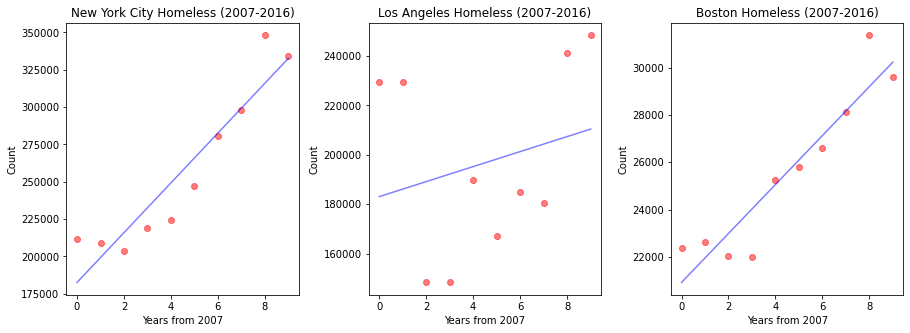

In [34]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
fig.subplots_adjust(hspace = .5, wspace=.3)

axs[0].scatter(x_ny, y_ny, alpha = 0.5, color = 'red', label = 'Observed')
axs[0].plot(x_ny, y_nyc_pred, alpha = 0.5, color = 'blue', label = 'Line of Best Fit')
axs[0].set_title("New York City Homeless (2007-2016)")
axs[0].set_xlabel("Years from 2007")
axs[0].set_ylabel("Count")

axs[1].scatter(x_LA, y_LA, alpha = 0.5, color = 'red', label = 'Observed')
axs[1].plot(x_ny, y_la_pred, alpha = 0.5, color = 'blue', label = 'Line of Best Fit')
axs[1].set_title("Los Angeles Homeless (2007-2016)")
axs[1].set_xlabel("Years from 2007")
axs[1].set_ylabel("Count")

axs[2].scatter(x_BOS, y_BOS, alpha = 0.5, color = 'red', label = 'Observed')
axs[2].plot(x_ny, y_bos_pred, alpha = 0.5, color = 'blue', label = 'Line of Best Fit')
axs[2].set_title("Boston Homeless (2007-2016)")
axs[2].set_xlabel("Years from 2007")
axs[2].set_ylabel("Count")

In [35]:
print(f"R-squared for Linear Model for Boston: {r2_score(y_BOS, y_bos_pred):.4f}")
print(f"R-squared for Linear Model for LA: {r2_score(y_LA, y_la_pred):.4f}")
print(f"R-squared for Linear Model for NYC: {r2_score(y_ny, y_nyc_pred):.4f}")

R-squared for Linear Model for Boston: 0.8702
R-squared for Linear Model for LA: 0.0594
R-squared for Linear Model for NYC: 0.8749


## Exploratory Data Analysis -- Boston Housing Data

In [36]:
# First 5 rows
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [37]:
# Dimension of the data
np.shape(data)

(506, 14)

In [38]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [39]:
# Designate categorical variables

cat_type = pd.CategoricalDtype(ordered=False) 
data['CHAS'] = data['CHAS'].astype(cat_type)

cat_type_ord = pd.CategoricalDtype(ordered=True) 
data['RAD'] = data['RAD'].astype(cat_type)

In [40]:
# Number of missing values
data.isnull().sum() # no missing values

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [41]:
# Summary of non-categorical data
data.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554696,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115877,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


In [42]:
# Summary of categorical data
print(data['CHAS'].unique()) # 2 categories
print(data['RAD'].unique()) # 9 categories

[0.0, 1.0]
Categories (2, float64): [0.0, 1.0]
[1.0, 2.0, 3.0, 5.0, 4.0, 8.0, 6.0, 7.0, 24.0]
Categories (9, float64): [1.0, 2.0, 3.0, 5.0, ..., 8.0, 6.0, 7.0, 24.0]


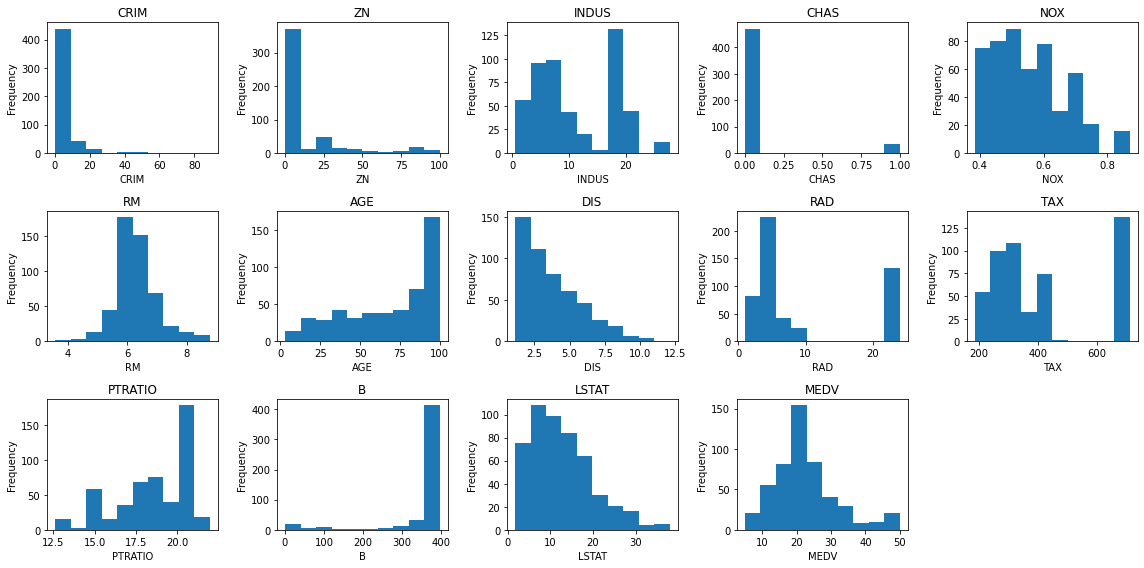

In [43]:
# Plot histograms of variables

plt.figure(figsize=(16, 8)) 

for i in column_names:
    plt.subplot(3, 5, column_names.index(i)+1)
    plt.hist(data[i])
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.title(i)
    plt.tight_layout()

<AxesSubplot:>

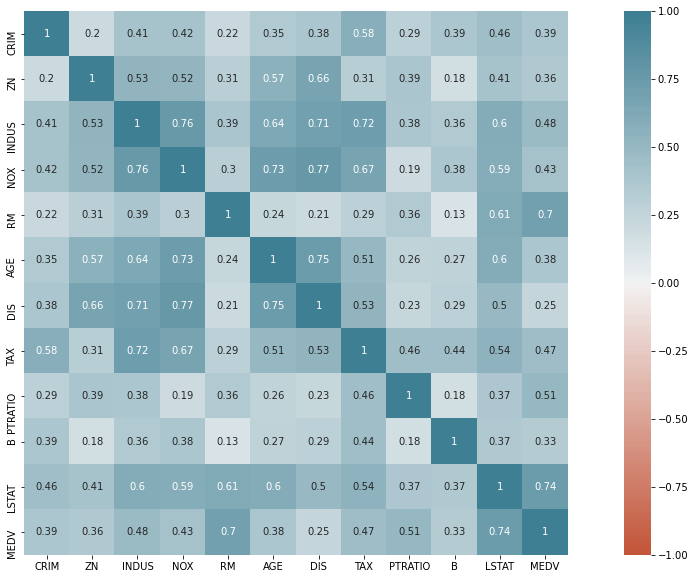

In [44]:
# Explore correlations between variables

plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True)

# 'RM', 'PTRATIO', and 'LSTAT' are all correlated > .4 with MEDV, indicating they may be good predictors

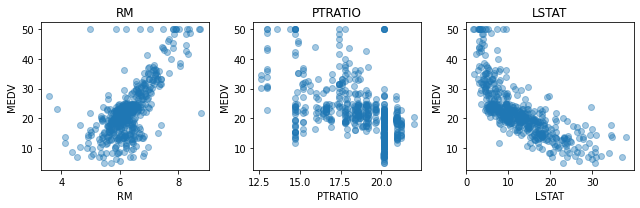

In [45]:
# Plot highly correlated variables with 'MEDV'

highly_corr_vars = ['RM', 'PTRATIO', 'LSTAT']

plt.figure(figsize=(9, 3)) 

for i in highly_corr_vars:
    plt.subplot(1, 3, highly_corr_vars.index(i)+1)
    plt.scatter(data[i], data['MEDV'], alpha = 0.4)
    plt.xlabel(i)
    plt.ylabel("MEDV")
    plt.title(i)
    plt.tight_layout() 

## Baseline Model - Linear regression with all predictors

After exploring the data through an EDA and completing the necessary data cleaning and preparation, we began our analysis by splitting the full dataset into an 80% / 20% training and test split. 

For our baseline model, we ran a simple linear regression using ‘LinearRegression’ from sklearn on our training sample. We designated our response variable as MEDV (median home value) and included all predictors included in the model. 

We then predicted on our test sample and calculated the mean squared error (MSE) for our training sample, MSE for our test sample, and an R-squared score, to evaluate the performance of our baseline model.  

In [46]:
## Split into train and test

# Designate predictors and response
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = data[predictors]
y = data['MEDV']

# Normalize
X_norm = preprocessing.normalize(X)

# Split into train and test
X_train_std, X_test_std, y_train, y_test = train_test_split(X_norm, y, random_state=42, test_size=0.2)

# Standardize
#sc = StandardScaler()
#X_train_std = sc.fit_transform(X_train)
#X_test_std = sc.transform(X_test)

In [47]:
## Conduct a linear regression to predict 'MEDV' from all predictors

# Initialize a Linear Regression model
lreg = LinearRegression()

# Fit the linear model on the train data
lreg.fit(X_train_std, y_train)

# Predict on the test data
y_test_pred = lreg.predict(X_test_std)
y_train_pred = lreg.predict(X_train_std)

# Use the mean_squared_error and r2_score functions to compute the test mse and r-squared
mse_test = mean_squared_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_test, y_test_pred)

# Print the MSE and r^2 values
print("The regression train MSE is", mse_train)
print("The regression test MSE is", mse_test)
print("The r-squared is", r2)

The regression train MSE is 21.404165146394384
The regression test MSE is 23.111529216753034
The r-squared is 0.6848447165718097


The regression coefficients are: {'CRIM': -89.30683892026435, 'ZN': 9.708250819401123, 'INDUS': 42.00565193839484, 'CHAS': 1308.6263917694796, 'NOX': -7100.8183800043535, 'RM': 2896.4771719535074, 'AGE': -3.811658486570648, 'DIS': -577.9019444164809, 'RAD': 128.34074252083064, 'TAX': 4.506617823664941, 'PTRATIO': -412.10261017940263, 'B': 12.081099711905676, 'LSTAT': -242.09489040500924}


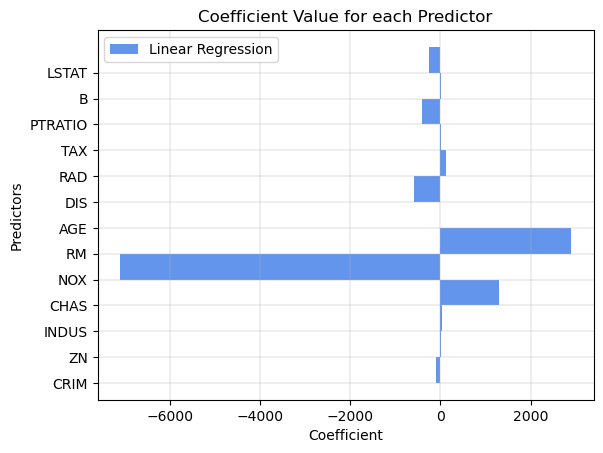

In [48]:
## Extract and plot coefficients

# Create a dictionary of the coefficients with the predictors as keys
lreg_coef = dict(zip(X.columns, np.transpose(lreg.coef_)))

# Linear regression coefficients
lreg_x = list(lreg_coef.keys())
lreg_y = list(lreg_coef.values())

# Print the coefficients
print("The regression coefficients are:", lreg_coef)

# Plot the coefficients
plt.rcdefaults()
plt.barh(lreg_x, lreg_y, 1.0, align='edge', color="cornflowerblue", label = "Linear Regression")
plt.grid(linewidth = 0.3)
plt.xlabel("Coefficient")
plt.ylabel("Predictors")
plt.title('Coefficient Value for each Predictor')
plt.legend(loc = 'best')
plt.show()

From this model, we learned that some predictors were more strongly related to MEDV. NOX, or the nitric oxides concentration, was negatively related to MEDV such that more nitric oxides relates to a lower median home value. Conversely, CHAS and RM were positively related to MEDV, such that homes on the river and homes with more rooms were related to a higher median home value.

## Regularization - Lasso Regression

Given our goal to select a subset of variables that are important in predicting home values, we chose to conduct a lasso regression next. This regularization method uses shrinkage to push some coefficients towards zero thereby eliminating them from the model, increasing interpretability and prediction accuracy. We fit a well-tuned lasso regression using ‘Lasso’ from sklearn. We selected the hyperparameter (alpha) that resulted in the smallest test error, and again calculated test MSE, train MSE, and R-squared values to assess model performance. 

The best alpha value for our lasso regression is 0.001
The lasso regression test MSE is 75.04543037399255
The lasso regression train MSE is 23.34119059222296
The lasso regression r-squared is 0.6896311978629901
The lasso regression coefficients are: {'CRIM': -76.85581077252266, 'ZN': 9.3448778779087, 'INDUS': 0.0, 'CHAS': 0.0, 'NOX': -0.0, 'RM': 2006.1566423012532, 'AGE': 0.6630886638423382, 'DIS': -368.8737820268966, 'RAD': 94.53641086226672, 'TAX': -2.864133331015696, 'PTRATIO': -365.88313817284836, 'B': 8.27202026261961, 'LSTAT': -317.94872931655175}


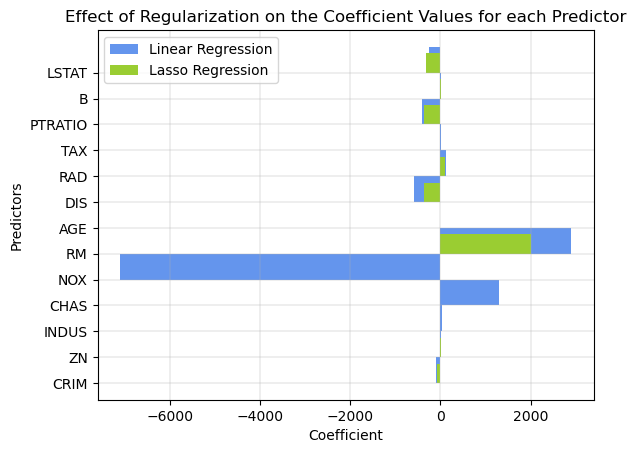

The following predictors were deemed important by the lasso regression model (i.e. coef != 0):

	['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['INDUS' 'CHAS' 'NOX']


In [49]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
lasso_test_mses = []

for alpha in alphas:
    
    # Create a Lasso Regression model with alpha
    lasso_reg = Lasso(alpha = alpha)

    # Fit the model on the train data
    lasso_reg.fit(X_train_std, y_train)

    # Predict on the test data using the trained model
    y_test_pred = lasso_reg.predict(X_test_std)
    
    # Calculate the test MSE
    mse_lasso = mean_squared_error(y_test, y_test_pred)

    # Store test MSE to list
    lasso_test_mses.append(mse_lasso)

# Find the best hyperparameter (alpha), i.e. the one that gives the smallest test error
best_parameter = alphas[lasso_test_mses.index(min(lasso_test_mses))]
print('The best alpha value for our lasso regression is', best_parameter)
  
# Run with best alpha parameter
lasso_reg = Lasso(alpha = best_parameter)
lasso_reg.fit(X_train_std, y_train)
y_test_pred = lasso_reg.predict(X_test_std)
y_train_pred = lasso_reg.predict(X_train_std)
lasso_reg_coefs = lasso_reg.coef_
lasso_reg_intercept = lasso_reg.intercept_

# Print MSE and r-squared values
mse_test_lasso = mean_squared_error(y_test, y_test_pred)
mse_train_lasso = mean_squared_error(y_train, y_train_pred)
r2_lasso = r2_score(y_test, y_test_pred)
print("The lasso regression test MSE is", mse_lasso)
print("The lasso regression train MSE is", mse_train_lasso)
print("The lasso regression r-squared is", r2_lasso)
    
# Make a dictionary of the predictors and the coefficients associated with them
lasso_coef = dict(zip(X.columns, np.transpose(lasso_reg.coef_))) 

# Get the Lasso coefficients for plotting
lasso_x = list(lasso_coef.keys())
lasso_y = list(lasso_coef.values())

# Print the coefficients
print("The lasso regression coefficients are:", lasso_coef)

# Plot the coefficients, along with the previous linear regression coefficients
plt.rcdefaults()
plt.barh(lreg_x, lreg_y, 1.0, align='edge', color="cornflowerblue", label = "Linear Regression")
plt.barh(lasso_x, lasso_y, 0.75, align='edge', color="yellowgreen", label = "Lasso Regression")
plt.grid(linewidth = 0.3)
plt.title("Effect of Regularization on the Coefficient Values for each Predictor")
plt.xlabel("Coefficient")
plt.ylabel("Predictors")
plt.legend(loc = 'best')
plt.show()

# Important predictors
bool_important_coefs = (lasso_reg_coefs != 0)
predictors_important = list(
    np.array(predictors)[bool_important_coefs]
)

print(
    "The following predictors were deemed important by "
    "the lasso regression model (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        np.array(predictors)[~bool_important_coefs],
    )
)

From this plot, we see that some predictors that were deemed ‘unimportant’ by the model (i.e., predictors with coefficients that were pushed to zero), and some were designated as ‘important’ (i.e., predictors with coefficients > 0). 

## Regularization - Lasso Regression with Interaction Terms

To further explore how our predictors relate to our outcome variable, we examined whether the interaction between each of our predictors relates to MEDV. Interactions are important to explore and include in a model when the effect of one variable changes depending on the value of another variable. Lasso regression is a well-suited method to explore interactions, as we can calculate the interactions between all pairs of variables, and the model will eliminate interaction terms that do not predict our outcome variable, resulting in a model that is still interpretable. 

We selected the ten predictors that were deemed ‘important’ by our lasso model and created interaction terms between each pair of variables. We conducted a well-tuned lasso regression with the important predictors and their interactions on the training sample, and evaluated the model on the test sample.

In [50]:
# We'll now fit a well-tuned Lasso regression model with all important predictors from our lasso model
# above and all the unique 2-way interactions between them

# Make arrays into dataframes
X_train_std = pd.DataFrame(X_train_std, columns = predictors)
X_test_std = pd.DataFrame(X_test_std, columns = predictors)

predictors_important = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Use `itertools.combinations` function to generate our interaction term combinations
combinations = list(
    itertools.combinations(predictors_important, 2)
)

interaction_colnames = []

for a, b in combinations:
    colname = '{} {}'.format(a, b)
    X_train_std[colname] = X_train_std[a].astype(float) * X_train_std[b].astype(float)
    X_test_std[colname] = X_test_std[a].astype(float) * X_test_std[b].astype(float)
    interaction_colnames.append(colname)

# Check new interaction columns were added
X_train_std.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'CRIM ZN', 'CRIM RM', 'CRIM AGE', 'CRIM DIS', 'CRIM RAD', 'CRIM TAX', 'CRIM PTRATIO', 'CRIM B', 'CRIM LSTAT', 'ZN RM', 'ZN AGE', 'ZN DIS', 'ZN RAD', 'ZN TAX', 'ZN PTRATIO', 'ZN B', 'ZN LSTAT', 'RM AGE', 'RM DIS', 'RM RAD', 'RM TAX', 'RM PTRATIO', 'RM B', 'RM LSTAT', 'AGE DIS', 'AGE RAD', 'AGE TAX', 'AGE PTRATIO', 'AGE B', 'AGE LSTAT', 'DIS RAD', 'DIS TAX', 'DIS PTRATIO', 'DIS B', 'DIS LSTAT', 'RAD TAX', 'RAD PTRATIO', 'RAD B', 'RAD LSTAT', 'TAX PTRATIO', 'TAX B', 'TAX LSTAT', 'PTRATIO B', 'PTRATIO LSTAT', 'B LSTAT'], dtype='object')

In [51]:
# Run new tuned lasso regression model with interaction terms

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
lasso_test_mses_int = []

for alpha in alphas:
    
    # Create a Lasso Regression model with alpha
    lasso_reg_int = Lasso(alpha = alpha, max_iter = 100000) #(number of iterations was increased to solve convergence wa

    # Fit the model on the train data
    lasso_reg_int.fit(X_train_std, y_train)

    # Predict on the test data using the trained model
    y_test_pred = lasso_reg_int.predict(X_test_std)
    
    # Calculate the test MSE
    mse_lasso = mean_squared_error(y_test, y_test_pred)

    # Store test MSE to list
    lasso_test_mses_int.append(mse_lasso)

# Find the best hyperparameter (alpha), i.e. the one that gives the smallest test error
best_parameter = alphas[lasso_test_mses.index(min(lasso_test_mses))]
print('The best alpha value for our lasso regression with interaction terms is', best_parameter)
  
# Run with best alpha parameter
lasso_reg_int = Lasso(alpha = best_parameter, max_iter = 100000) #(number of iterations was increased to solve convergence warning)
lasso_reg_int.fit(X_train_std, y_train)
y_test_pred = lasso_reg_int.predict(X_test_std)
y_train_pred = lasso_reg_int.predict(X_train_std)
lasso_reg_int_coefs = lasso_reg_int.coef_
lasso_reg_int_intercept = lasso_reg_int.intercept_

# Print MSE and r-squared values
mse_test_lasso_int = mean_squared_error(y_test, y_test_pred)
mse_train_lasso_int = mean_squared_error(y_train, y_train_pred)

r2_lasso_int = r2_score(y_test, y_test_pred)
print("The lasso regression with interaction terms test MSE is", mse_test_lasso_int)
print("The lasso regression with interaction terms train MSE is", mse_train_lasso_int)
print("The lasso regression with interaction terms r-squared is", r2_lasso_int)
    
# Make a dictionary of the predictors and the coefficients associated with them
lasso_coef_int = dict(zip(X_train_std.columns, np.transpose(lasso_reg_int.coef_))) 

# Get the Lasso coefficients for plotting
lasso_x_int = list(lasso_coef_int.keys())
lasso_y_int = list(lasso_coef_int.values())

# Print the coefficients
print(
    "The intercept and coefficients for the lasso regression with interaction terms model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", lasso_reg_int_intercept
    )
)

for predictor, coef in zip(list(X_train_std.columns), lasso_reg_int_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))



The best alpha value for our lasso regression with interaction terms is 0.001
The lasso regression with interaction terms test MSE is 23.239585266812693
The lasso regression with interaction terms train MSE is 21.873995352240836
The lasso regression with interaction terms r-squared is 0.6830985084186083
The intercept and coefficients for the lasso regression with interaction terms model are:

	intercept           10.8962
	CRIM                -72.0939
	ZN                  0.0000
	INDUS               -0.0000
	CHAS                0.0000
	NOX                 -0.0000
	RM                  1747.4583
	AGE                 -0.0000
	DIS                 -370.9132
	RAD                 78.1314
	TAX                 9.5185
	PTRATIO             -354.1731
	B                   0.0000
	LSTAT               -0.0000
	CRIM ZN             0.0000
	CRIM RM             -0.0000
	CRIM AGE            -0.0000
	CRIM DIS            -0.0000
	CRIM RAD            -0.0000
	CRIM TAX            -0.0000
	CRIM PTRATIO        -

In [52]:
# Important predictors
bool_important_coefs = (lasso_reg_int_coefs != 0)
predictors_important = list(
    np.array(X_train_std.columns)[bool_important_coefs]
)

print(
    "The following predictors were deemed important by "
    "the lasso regression model with interactions (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        np.array(X_train_std.columns)[~bool_important_coefs],
    )
)

The following predictors were deemed important by the lasso regression model with interactions (i.e. coef != 0):

	['CRIM', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'ZN B', 'RM B', 'AGE B', 'TAX B', 'TAX LSTAT']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['ZN' 'INDUS' 'CHAS' 'NOX' 'AGE' 'B' 'LSTAT' 'CRIM ZN' 'CRIM RM'
 'CRIM AGE' 'CRIM DIS' 'CRIM RAD' 'CRIM TAX' 'CRIM PTRATIO' 'CRIM B'
 'CRIM LSTAT' 'ZN RM' 'ZN AGE' 'ZN DIS' 'ZN RAD' 'ZN TAX' 'ZN PTRATIO'
 'ZN LSTAT' 'RM AGE' 'RM DIS' 'RM RAD' 'RM TAX' 'RM PTRATIO' 'RM LSTAT'
 'AGE DIS' 'AGE RAD' 'AGE TAX' 'AGE PTRATIO' 'AGE LSTAT' 'DIS RAD'
 'DIS TAX' 'DIS PTRATIO' 'DIS B' 'DIS LSTAT' 'RAD TAX' 'RAD PTRATIO'
 'RAD B' 'RAD LSTAT' 'TAX PTRATIO' 'PTRATIO B' 'PTRATIO LSTAT' 'B LSTAT']


As expected, many of the coefficients of the predictors were shrunk to zero, and several predictors, listed above, remained 'important'. 

Interpreting these coefficients, we see that lower crime rates, more rooms, closer distance to Boston employment center, more accessibility to highways, a higher tax rate, and a lower pupil-teacher ratio predict higher median home values in Boston. From the interaction terms, we see that several variables interact with B, which refers to a formula that includes the number of black individuals. This formula makes this variable hard to interpret, however, as the transformation assumes parabolic relationship between the proportion of black individuals and housing prices. If we were to analyze this datset in a future analysis, we would need to obtain the raw data to look at the raw proportion of black individuals to fully parse these interactions.


## Comparison of Linear Regression, Lasso Regression, and Lasso + Interaction 

In [53]:
d = {'Model': ["Linear Regression", "Lasso Regression", "Lasso Regression with Interaction Terms"], 
     'Training MSE': [mse_train, mse_train_lasso, mse_train_lasso_int], 
     'Test MSE': [mse_test, mse_test_lasso, mse_test_lasso_int],
     'R-Squared': [r2, r2_lasso, r2_lasso_int]}
linear_results_df = pd.DataFrame(data=d)
linear_results_df

,Model,Training MSE,Test MSE,R-Squared
0,Linear Regression,21.404165,23.111529,0.684845
1,Lasso Regression,23.341191,22.760518,0.689631
2,Lasso Regression with Interaction Terms,21.873995,23.239585,0.683099


Our linear regression performed best on the training dataset, but our lasso regression without interaction terms had the lowest test MSE and the highest R-squared. Thus, between these three models, the lasso regression performed best.

## PCA Model - Controlling for collinearity
The correlation matrix above shows highly correlated predictors (>0.7). Is it possible to use a PCA transformation to eliminate possible effects of multicollinearity?

In [54]:
# Split the data into train and test sets
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X = data[predictors]
y = data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Standardize X_train and X_test
sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

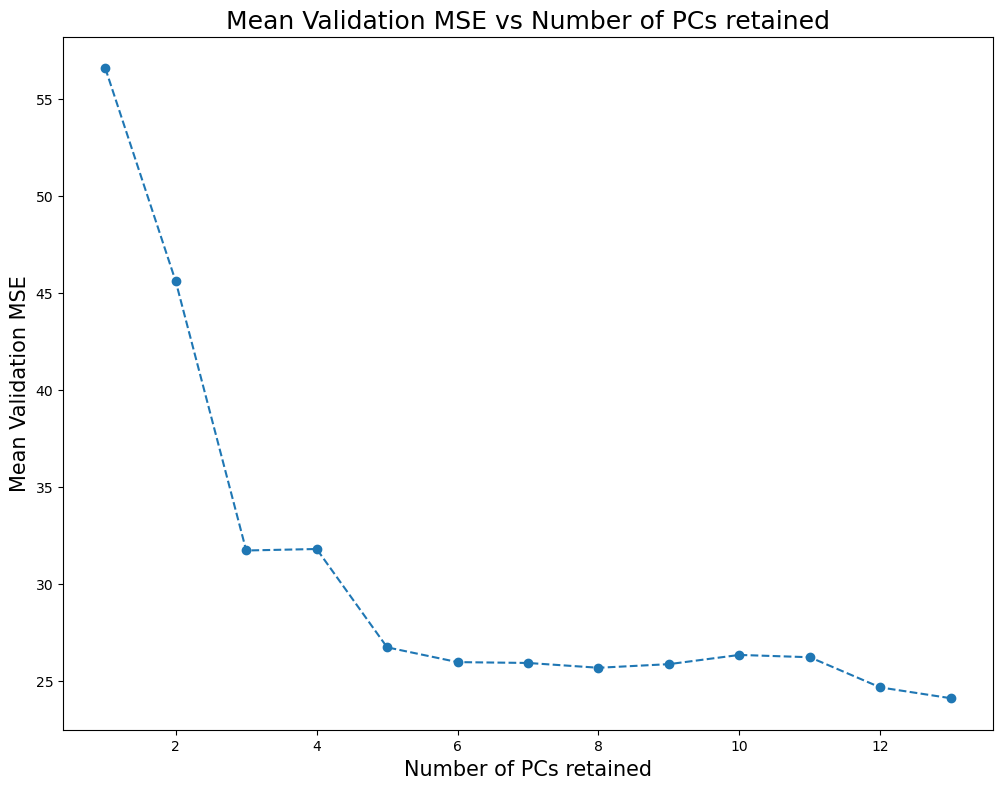

The best k is 13.


In [55]:
k_list = np.arange(1,len(predictors)+1)
validation_mse_list = []

# Apply the PCA transformation
for k in k_list:
    pca = PCA(n_components=k)
    X_train_k = pca.fit_transform(X_train_std)
    mse_score = cross_validate(LinearRegression(), X_train_k, y_train, cv=10,\
    scoring="neg_mean_squared_error")

    validation_mse_list.append(-1*mse_score['test_score'].mean())

# Plot MSE vs PCs for each value of k
plt.figure(figsize=(12, 9))
plt.plot(k_list, validation_mse_list, marker='o', ls='--')
plt.xlabel('Number of PCs retained', fontsize=15)
plt.ylabel('Mean Validation MSE', fontsize=15)
plt.title('Mean Validation MSE vs Number of PCs retained', fontsize=18)
plt.show()

best_k = k_list[np.argmin(validation_mse_list)]
print(f"The best k is {best_k}.")

In [56]:
# Recalculate PCA with best k
pca = PCA(n_components=best_k)
X_train_k = pca.fit_transform(X_train_std)
X_test_k = pca.transform(X_test_std)
pcreg = LinearRegression().fit(X_train_k, y_train)
y_pred = pcreg.predict(X_test_k)
y_pred_t = pcreg.predict(X_train_k)

pcr_MSE_train = mean_squared_error(y_train, y_pred_t)
print(f"MSE train for PCA model is {pcr_MSE_train:.4f}")

pcr_MSE_test = mean_squared_error(y_test, y_pred)
print(f"MSE test for PCA model is {pcr_MSE_test:.4f}")

pcr_r2_score = r2_score(y_test, y_pred)
print(f"R^2 score for PCA model is {pcr_r2_score:.4f}")

MSE train for PCA model is 21.6414
MSE test for PCA model is 24.2907
R^2 score for PCA model is 0.6688


**It appears the answer to the question posed above is no**--the model needs all predictors to match performance of the baseline linear model. 


## Interaction PCA Model - Controlling for collinearity
The PCA transformation only using the original 13 predictors did not improve the baseline model. The question then becomes: is it possible to add interaction terms and then use a PCA transformation to eliminate possible effects of multicollinearity?

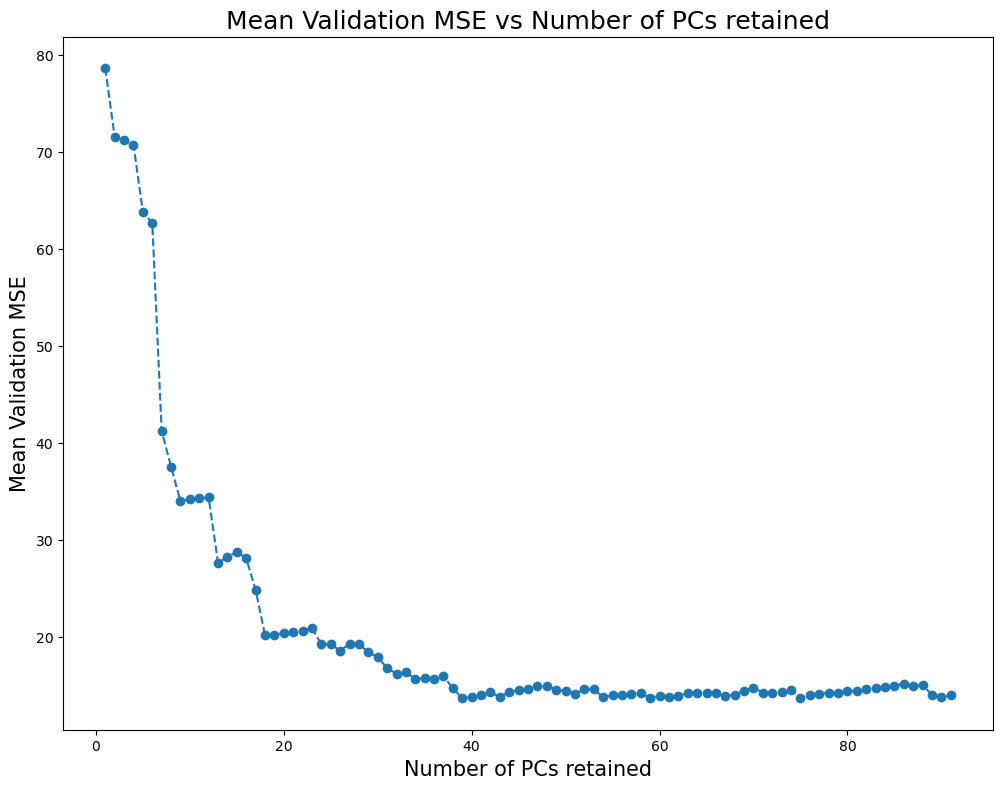

The best k with interaction terms is 39.


In [57]:
# Create interaction terms for train and test
interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_train_int = interaction.fit_transform(X_train_std)
X_test_int = interaction.fit_transform(X_test_std)

k_list = np.arange(1,X_train_int.shape[1]+1)
validation_mse_list = []

# Apply the PCA transformation
for k in k_list:
    pca = PCA(n_components=k)
    X_train_k = pca.fit_transform(X_train_int)
    mse_score = cross_validate(LinearRegression(), X_train_k, y_train, cv=10,\
    scoring="neg_mean_squared_error")

    validation_mse_list.append(-1*mse_score['test_score'].mean())

# Plot MSE vs PCs for each value of k
plt.figure(figsize=(12, 9))
plt.plot(k_list, validation_mse_list, marker='o', ls='--')
plt.xlabel('Number of PCs retained', fontsize=15)
plt.ylabel('Mean Validation MSE', fontsize=15)
plt.title('Mean Validation MSE vs Number of PCs retained', fontsize=18)
plt.show()

best_k_int = k_list[np.argmin(validation_mse_list)]
print(f"The best k with interaction terms is {best_k_int}.")

In [58]:
# Recalculate PCA with best k
pca_int = PCA(n_components=best_k_int)
X_train_k_int = pca_int.fit_transform(X_train_int)
X_test_k_int = pca_int.transform(X_test_int)
pcreg_int = LinearRegression().fit(X_train_k_int, y_train)
y_pred_int = pcreg_int.predict(X_test_k_int)
y_pred_t_int = pcreg_int.predict(X_train_k_int)

pcr_r2_score_int = r2_score(y_test, y_pred_int)
print(f"R^2 score for interaction PCA model is {pcr_r2_score_int:.4f}")

pcr_MSE_train_int = mean_squared_error(y_train, y_pred_t_int)
print(f"MSE train for interaction PCA model is {pcr_MSE_train_int:.4f}")

pcr_MSE_test_int = mean_squared_error(y_test, y_pred_int)
print(f"MSE test for interaction PCA model is {pcr_MSE_test_int:.4f}")

R^2 score for interaction PCA model is 0.8358
MSE train for interaction PCA model is 9.6965
MSE test for interaction PCA model is 12.0386


In [59]:
d = {'Model': ["PCA Linear Regression", "PCA Linear Regression with Interaction Terms"], 
     'Training MSE': [pcr_MSE_train, pcr_MSE_train_int], 
     'Test MSE': [pcr_MSE_test, pcr_MSE_test_int],
     'R-Squared': [pcr_r2_score, pcr_r2_score_int]}
pcr_results_df = pd.DataFrame(data=d)
pcr_results_df

,Model,Training MSE,Test MSE,R-Squared
0,PCA Linear Regression,21.641378,24.290650,0.668766
1,PCA Linear Regression with Interaction Terms,9.696547,12.038558,0.835839


**The answer to the second question is yes**--the model can be significantly improved by including just interaction terms and then performing a principle component analysis. Looking at the variance plots below, nearly all of the model variance can be explained by 39 principle components when including interaction terms.



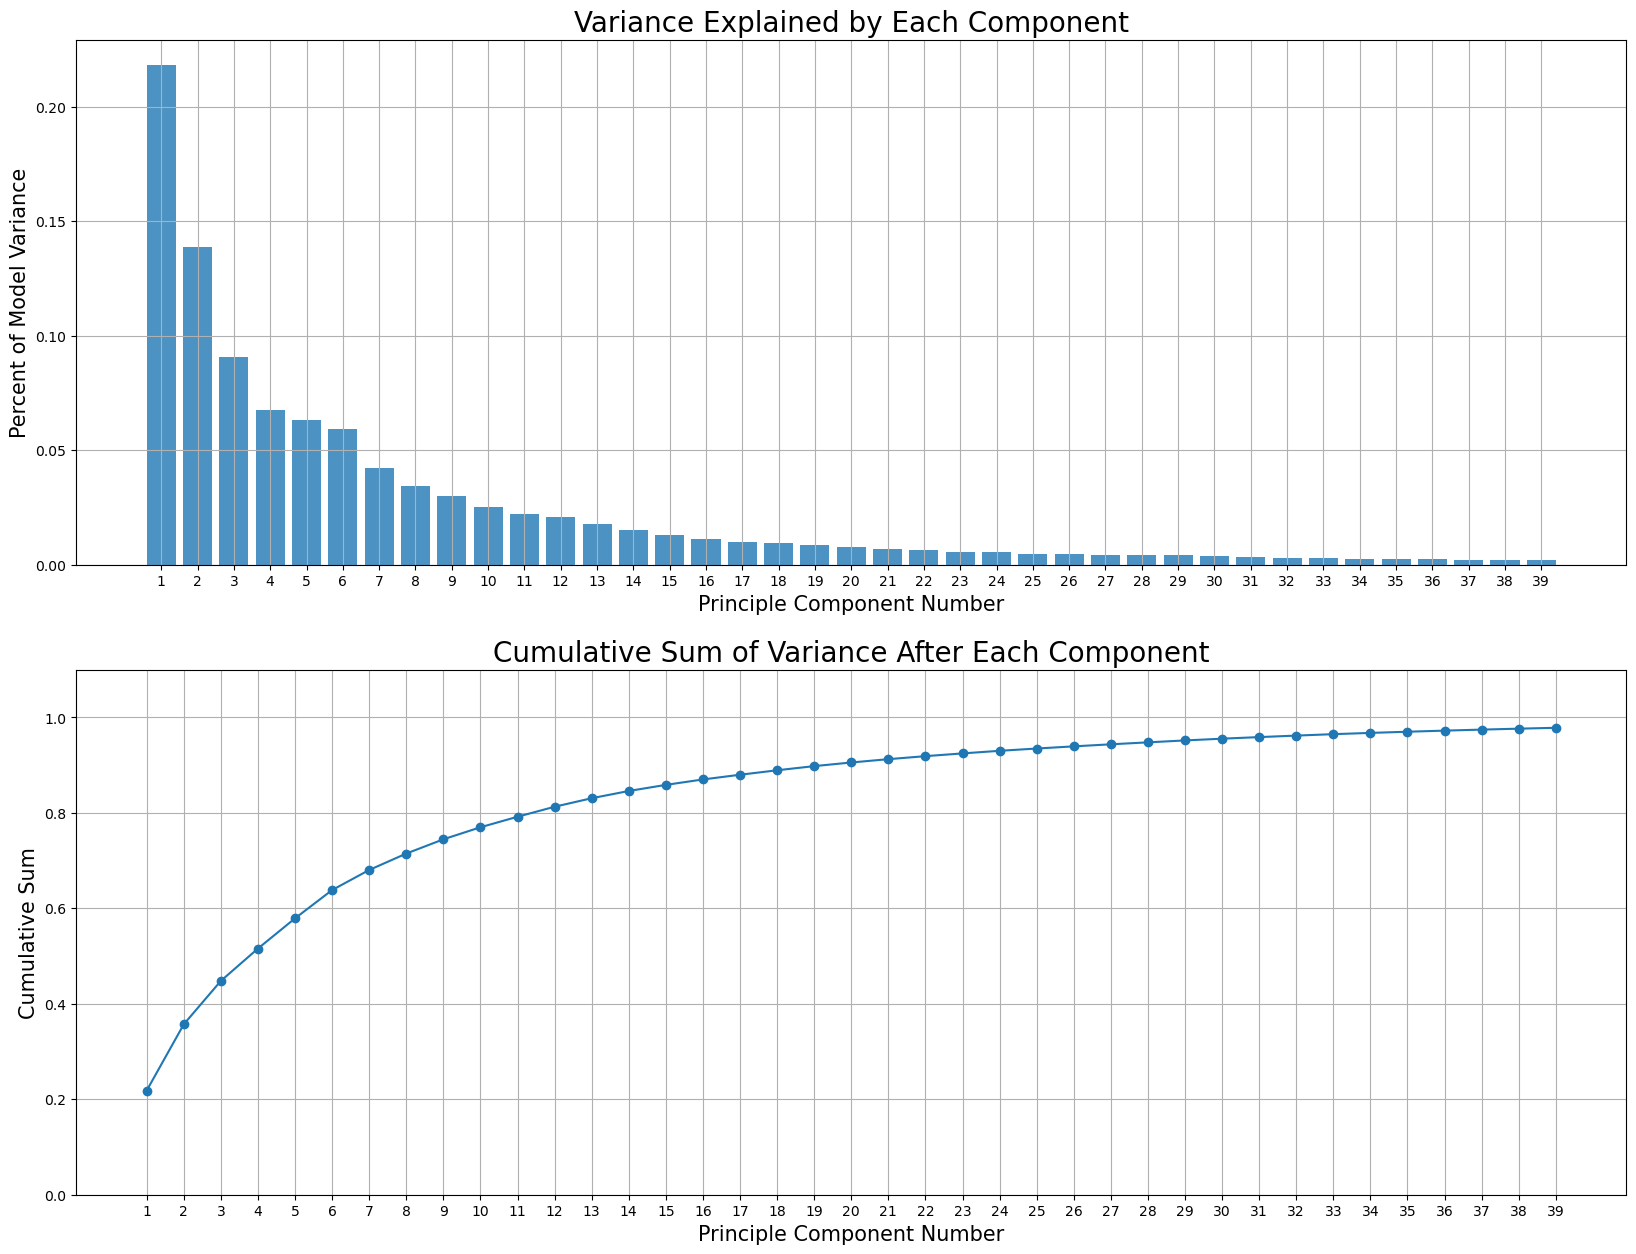

In [60]:
fig, ax = plt.subplots(nrows=2, figsize=(20,15))
ax1, ax2 = ax.ravel()

# Plot the variance explained by each component
ratio = pca_int.explained_variance_ratio_
xticks = np.arange(1,pca_int.explained_variance_ratio_.shape[0]+1)
ax1.bar(range(len(ratio)), ratio, alpha=0.8)
ax1.set_title('Variance Explained by Each Component', fontsize=20)
ax1.set_xticks(range(len(ratio)))
ax1.set_xticklabels(xticks)
ax1.set_ylabel('Percent of Model Variance', fontsize=15)
ax1.set_xlabel('Principle Component Number', fontsize=15)
ax1.grid()

# Plot the cumulative sum of variance explained by each compoment
ax2.plot(np.cumsum(ratio), 'o-')
ax2.set_title('Cumulative Sum of Variance After Each Component', fontsize=20)
ax2.set_ylim(0,1.1)
ax2.set_xticks(range(len(ratio)))
ax2.set_xticklabels(xticks)
ax2.set_ylabel('Cumulative Sum', fontsize=15)
ax2.set_xlabel('Principle Component Number', fontsize=15)
ax2.grid();

One important note, however:

*****INTERACTION PCA MODEL IS NOT EASY TO INTERPRET LIKE THE LASSO REGRESSION WITH INTERACTION TERMS*****

The Lasso model with interaction terms is easier to understand (better interpretability). Interpretability is a major goal of this exercise. Teasing out the predictors that make up our 39 principle components would be tedious and wouldn't bring us closer to understanding which factors affect median home values the most. This model is an interesting experiment, but ultimately there are better methods to utilize that are easier to understand. 

## Decision Tree Regressor

<div class='exercise-r'>

We first determine the best depth for our decision tree regressor using cross-validation. To do this, we do the following. For each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set.

- Perform 5-fold cross-validation with the entire **training** set, while storing the mean validation mean squared error and the validation standard deviation in variables named `cvmeans` and `cvstds`, respectively.

</div>

In [61]:
# set the highest depth of a decision tree
max_depth = 20

# for storing training MSE values
training_error = []

# for storing mean validation MSE and validation standard deviation values
cvmeans, cvstds = [], []

# for each tree depth from 1 to 20 inclusive
for depth in range(1, max_depth + 1):
    
    # Initialize a Decision Tree regressor
    dtree = DecisionTreeRegressor(max_depth=depth, random_state=109)

    # Fit a decision tree to the entire training set.
    dtree.fit(X_train_std, y_train)
    
    # Perform cross-validation on the entire data with 10 folds and get the mse_scores
    mse_score = cross_validate(dtree, X_train_std, y_train, cv=10, scoring="neg_mean_squared_error", 
                               return_train_score=True)
    
    # Compute the standard deviation of the validation MSE and store in list
    cvstds.append(np.std(mse_score['test_score']))
    
    # Compute the mean of the training error and store in list 
    training_error.append(-1*np.mean(mse_score['train_score']))
    
    # Compute the mean of the cross validation error and store in list 
    cvmeans.append(-1*np.mean(mse_score['test_score']))

In [62]:
# Get the numbers for the +/- 0.5 standard deviation bounds
half_stds = [0.5 * std for std in cvstds]

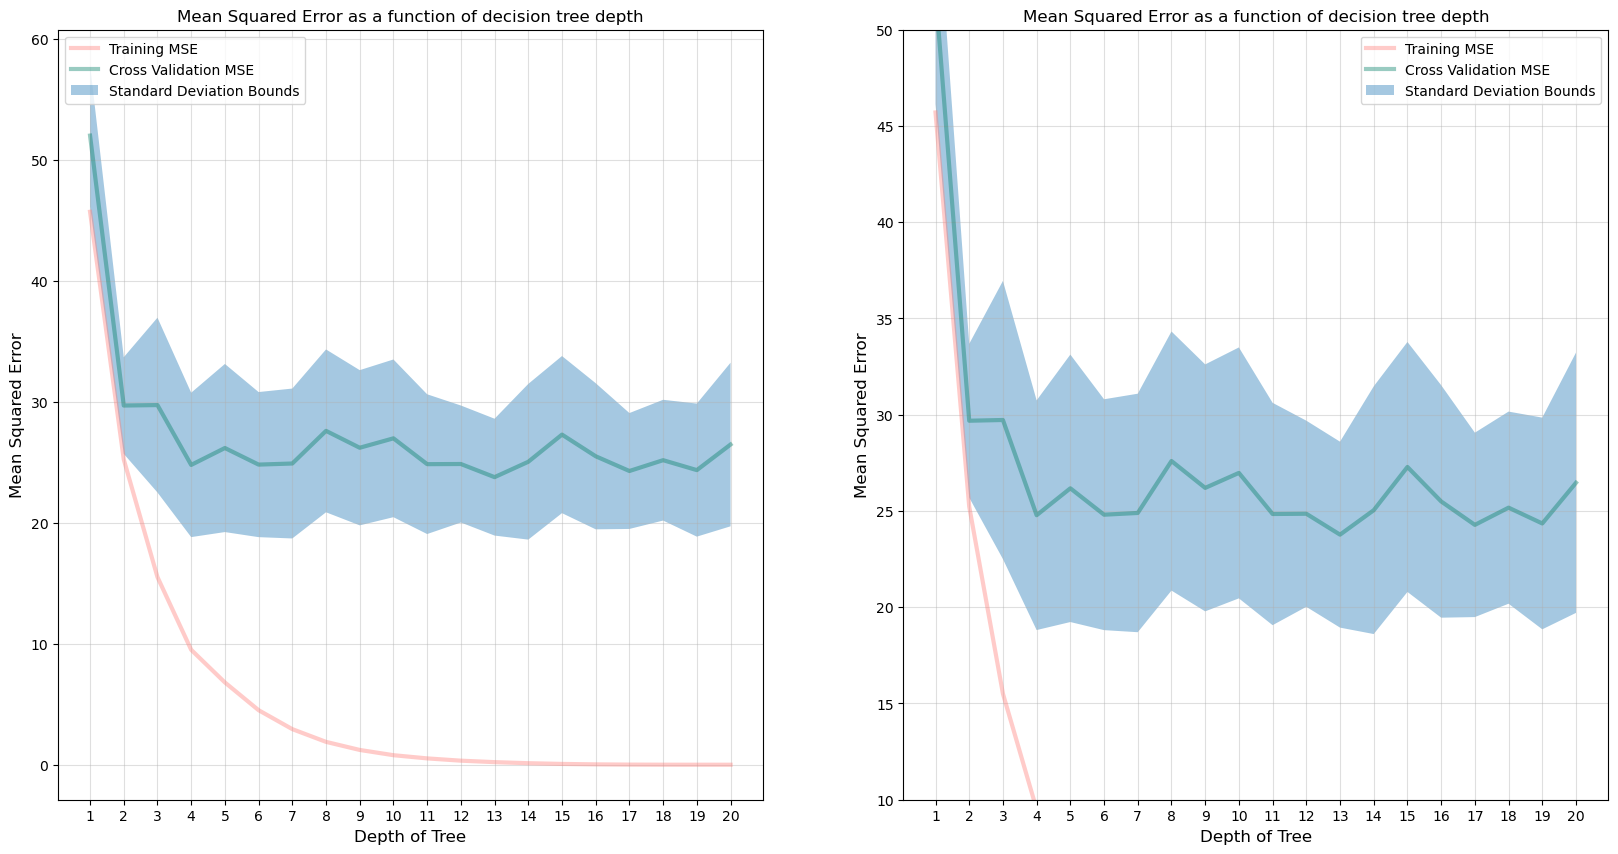

In [63]:
# Create a plot of the train and test MSEs to get the best tree depth
fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    
    # Plot the training MSE with labels
    ax.plot(range(1, max_depth + 1), training_error, label = 'Training MSE', linewidth=3, 
             color='#FF7E79', alpha=0.4)

    # Plot the test MSE with labels
    ax.plot(range(1, max_depth + 1), cvmeans, label = 'Cross Validation MSE', linewidth=3, 
             color="#007D66", alpha=0.4)

    # Plot the +/- 2 standard deviation bounds
    ax.fill_between(range(1, max_depth + 1), np.array(cvmeans) - (half_stds), 
                     np.array(cvmeans) + (half_stds), label = 'Standard Deviation Bounds',alpha=0.4)

    # Set the labels
    ax.set_xlabel('Depth of Tree', fontsize=12)
    ax.set_xticks(range(1, 21))
    ax.set_ylabel('Mean Squared Error', fontsize=12)
    ax.set_title("Mean Squared Error as a function of decision tree depth")
    ax.legend(frameon = True, loc = 'upper left')
    ax.grid(":", alpha=0.4)
    if idx == 1:
        ax.legend(frameon = True, loc = 'upper right')
        ax.set_ylim(10, 50)
    idx += 1

In [64]:
# Get the lowest validation MSE value
min_cv_mse = min(cvmeans)
# Get the depth corresponding to the lowest MSE value
best_depth = cvmeans.index(min_cv_mse) + 1

print(f'The best depth is: {best_depth}')

The best depth is: 13


In [65]:
best_depth = 13

# initialize a new decision tree with the best depth selected from above
best_dtr = DecisionTreeRegressor(max_depth=best_depth, random_state=109)

# fit the tree on the train set
best_dtr.fit(X_train_std, y_train)

# predict on the train and test sets
y_train_pred = best_dtr.predict(X_train_std)

y_test_pred = best_dtr.predict(X_test_std)

# compute train and test MSE values
best_cv_tree_train_mse = mean_squared_error(y_train_pred, y_train)
best_cv_tree_test_mse = mean_squared_error(y_test_pred, y_test)

# compute the r-squared value
best_r_squared_dtr = best_dtr.score(X_test_std, y_test)

print(f'The best train MSE is: {best_cv_tree_train_mse:.4f}')
print(f'The best test MSE is: {best_cv_tree_test_mse:.4f}')
print(f'The r^2 of the best model is: {best_r_squared_dtr:.4f}')

The best train MSE is: 0.0392
The best test MSE is: 11.3409
The r^2 of the best model is: 0.8454


# Bagging with Decision Tree Regressors

In [66]:
# choose a depth that will cause the decision tree to overfit
tree_depth = 20

# initialize a decision tree that will serve as a weak learner to be used in creating our bagging model
dtree_overfitting = DecisionTreeRegressor(max_depth = tree_depth, random_state=109)

# fit the weak learner on the test set
dtree_overfitting.fit(X_train_std, y_train)

# predict on the train and test sets
y_pred_train = dtree_overfitting.predict(X_train_std)

y_pred_test = dtree_overfitting.predict(X_test_std)

# compute the train and test MSE values
dtree_over_train_mse = mean_squared_error(y_pred_train, y_train)

dtree_over_test_mse = mean_squared_error(y_pred_test, y_test)

# compute the r-squared value
r_squared_dtr_over = dtree_overfitting.score(X_test_std, y_test)

print(f'The train MSE of a decision tree of depth {tree_depth} is: {dtree_over_train_mse:.4f}')
print(f'The test MSE of a decision tree of depth {tree_depth} is: {dtree_over_test_mse:.4f}')
print(f'The r^2 of a decision tree of depth {tree_depth} is: {r_squared_dtr_over:.4f}')

The train MSE of a decision tree of depth 20 is: 0.0000
The test MSE of a decision tree of depth 20 is: 23.5947
The r^2 of a decision tree of depth 20 is: 0.6783


<div class='exercise-r'>

Here we will use the `tree_depth` chosen above to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- First, we create a `bagger` function to generate 55 boostrapped sets of decision tree predictions for both the training and test data.
- Then, make a single call to the `bagger` function to return our bootstrapped results.
- The function stores the returned results as: 
  1. `bagging_train_df`: a dataframe containing the training data predictions
  2. `bagging_test_df`: a dataframe containing the test data predictions
  3. `bagging_models_list`: a list containing the 55 fitted model objects (i.e. fitted estimators)

</div>

In [67]:
# a helper function to help us with creating the bagging model
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe, (2) bagging_test_df
              and (3) bagging_models_list
              containing every trained DecisionTreeRegressor model
              object (i.e. estimator), one estimator for each bootstrap
    """
    bagging_models_list = []
    # set random seed
    np.random.seed = random_seed
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        
        model = DecisionTreeRegressor(max_depth=tree_depth, random_state=109)
        
        fitted_model = model.fit(bootstrapped_X, bootstrapped_y)
        
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"bootstrap model {x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"bootstrap model {x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list

In [68]:
assert tree_depth == 20
# specify number of required bootrapped trees
n_trees = 55 

# generate predictions using bagger function
bagging_train_df, bagging_test_df, bagging_models_list = bagger(
    n_trees, tree_depth, X_train_std, y_train, X_test_std, random_seed=0
)

# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,bootstrap model 0,bootstrap model 1,bootstrap model 2,bootstrap model 3,bootstrap model 4,bootstrap model 5,bootstrap model 6,bootstrap model 7,bootstrap model 8,bootstrap model 9,bootstrap model 10,bootstrap model 11,bootstrap model 12,bootstrap model 13,bootstrap model 14,bootstrap model 15,bootstrap model 16,bootstrap model 17,bootstrap model 18,bootstrap model 19,bootstrap model 20,bootstrap model 21,bootstrap model 22,bootstrap model 23,bootstrap model 24,bootstrap model 25,bootstrap model 26,bootstrap model 27,bootstrap model 28,bootstrap model 29,bootstrap model 30,bootstrap model 31,bootstrap model 32,bootstrap model 33,bootstrap model 34,bootstrap model 35,bootstrap model 36,bootstrap model 37,bootstrap model 38,bootstrap model 39,bootstrap model 40,bootstrap model 41,bootstrap model 42,bootstrap model 43,bootstrap model 44,bootstrap model 45,bootstrap model 46,bootstrap model 47,bootstrap model 48,bootstrap model 49,bootstrap model 50,bootstrap model 51,bootstrap model 52,bootstrap model 53,bootstrap model 54
0,12,12,12,12,12,12,12,12,12,10,12,12,19,12,14,8,12,12,12,12,19,12,13,12,12,8,11,12,19,12,10,12,12,12,12,12,12,13,12,13,8,8,14,12,12,12,12,13,13,12,12,12,12,12,13
1,19,19,19,19,19,18,19,20,22,18,19,21,19,21,19,19,19,20,18,18,19,19,19,19,20,19,19,19,19,19,20,19,19,20,20,20,18,18,19,19,20,19,19,18,19,19,19,19,19,19,19,19,19,19,19
2,21,19,19,19,19,22,19,19,23,23,17,19,17,23,23,22,19,19,19,19,19,19,19,21,17,19,19,23,19,19,19,19,19,19,19,19,19,22,19,23,20,24,17,22,23,22,19,19,19,17,19,19,19,19,19
3,13,12,10,13,16,13,13,17,13,10,13,13,13,13,13,13,12,13,13,13,13,12,13,13,13,13,13,13,13,10,13,13,9,12,13,13,13,13,13,13,13,13,13,19,13,11,13,13,13,13,13,13,12,13,13
4,21,18,19,18,18,18,19,19,18,18,18,18,18,18,18,18,19,18,18,18,18,19,19,18,18,16,18,18,19,19,18,18,18,20,19,18,21,18,16,16,18,18,21,18,18,18,20,21,22,18,18,18,18,19,18


,bootstrap model 0,bootstrap model 1,bootstrap model 2,bootstrap model 3,bootstrap model 4,bootstrap model 5,bootstrap model 6,bootstrap model 7,bootstrap model 8,bootstrap model 9,bootstrap model 10,bootstrap model 11,bootstrap model 12,bootstrap model 13,bootstrap model 14,bootstrap model 15,bootstrap model 16,bootstrap model 17,bootstrap model 18,bootstrap model 19,bootstrap model 20,bootstrap model 21,bootstrap model 22,bootstrap model 23,bootstrap model 24,bootstrap model 25,bootstrap model 26,bootstrap model 27,bootstrap model 28,bootstrap model 29,bootstrap model 30,bootstrap model 31,bootstrap model 32,bootstrap model 33,bootstrap model 34,bootstrap model 35,bootstrap model 36,bootstrap model 37,bootstrap model 38,bootstrap model 39,bootstrap model 40,bootstrap model 41,bootstrap model 42,bootstrap model 43,bootstrap model 44,bootstrap model 45,bootstrap model 46,bootstrap model 47,bootstrap model 48,bootstrap model 49,bootstrap model 50,bootstrap model 51,bootstrap model 52,bootstrap model 53,bootstrap model 54
0,22,21,20,23,23,23,22,22,24,25,30,26,21,22,22,21,18,23,22,22,27,20,21,22,21,22,23,20,22,22,24,19,21,22,23,23,22,21,23,28,22,21,24,22,28,25,21,20,24,28,22,24,24,23,21
1,33,28,35,33,22,31,33,37,28,33,30,33,31,33,22,26,26,33,31,32,26,26,33,28,32,33,32,28,32,32,22,32,32,32,33,31,33,38,32,32,33,33,28,33,30,30,30,33,33,33,25,33,32,33,31
2,19,17,20,15,15,27,19,19,15,18,18,8,8,18,18,20,15,18,17,15,18,20,17,18,16,19,18,17,8,15,8,20,18,20,15,20,20,15,15,15,17,19,8,13,18,17,17,20,16,27,15,15,21,18,18
3,20,25,24,24,28,23,28,25,23,23,17,24,28,28,24,22,23,24,23,23,23,23,25,25,21,24,23,22,25,24,22,22,23,18,22,25,24,20,23,20,24,24,21,22,24,24,23,18,22,22,24,24,23,24,25
4,15,12,13,16,15,17,12,16,17,14,14,15,15,17,17,17,14,16,17,14,15,16,15,19,14,19,15,14,15,15,16,19,13,16,15,14,17,15,14,21,17,16,17,15,19,13,15,15,17,17,14,15,19,13,23


In [69]:
# have the bagging model predict on the train and test data
bag_y_pred_train = np.mean(bagging_train_df.iloc[:, :], axis=1)

bag_y_pred_test = np.mean(bagging_test_df.iloc[:, :], axis=1)

# compute the train and test MSE values
bagging_mse_train = mean_squared_error(bag_y_pred_train, y_train)

bagging_mse_test = mean_squared_error(bag_y_pred_test, y_test)

# compute the r-squared value
bagging_r2 = r2_score(bag_y_pred_test, y_test)

print(f'The MSE of the bagging model on the train set is {bagging_mse_train:.4f}')
print(f'The MSE of the bagging model on the test set is {bagging_mse_test:.4f}')
print(f'The r^2 of the bagging model on the test set is {bagging_r2:.4f}')

The MSE of the bagging model on the train set is 2.1088
The MSE of the bagging model on the test set is 9.5734
The r^2 of the bagging model on the test set is 0.8474


## Random Forest Regressor

<div class='exercise-r'>

We fit a `RandomForestRegressor` to the scaled `X_train_std` data, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. We then evaluate and report this regressor's mean squared error on the training and test sets. Then, we assign those error values to the variables `random_forest_train_mse` and `random_forest_test_mse`.

</div>

In [70]:
# ensure that our individual decision trees are overfitting
assert tree_depth == 20
# Define a Random Forest regressor
random_forest = RandomForestRegressor(max_depth=tree_depth, 
                                      n_estimators=55, 
                                      max_features="sqrt", 
                                      random_state=109)

# Fit the model on the training set
random_forest.fit(X_train_std, y_train)

# predict on the train and test data
rf_y_pred_train = random_forest.predict(X_train_std)

rf_y_pred_test = random_forest.predict(X_test_std)

# compute the train and test MSE values
random_forest_train_mse = mean_squared_error(rf_y_pred_train, y_train)

random_forest_test_mse = mean_squared_error(rf_y_pred_test, y_test)

# compute the r-squared value
random_forest_r_squared = random_forest.score(X_test_std, y_test)

print(f'The train MSE for the random forest model is: {random_forest_train_mse:.4f}')
print(f'The test MSE for the random forest model is: {random_forest_test_mse:.4f}')
print(f'The r^2 for the random forest model is: {random_forest_r_squared:.4f}')

The train MSE for the random forest model is: 1.8110
The test MSE for the random forest model is: 11.3606
The r^2 for the random forest model is: 0.8451


Among all of the decision trees we fit in the bagging process (i.e. each of the fitted model objects stored in bagging_models_list), we find how many times is each feature used as the top/first node. We do the same for each tree in the random forest we just fit. We assign the answers to these questions to two pandas Series called top_predictors_bagging and top_predictors_rf, and display them.

In [71]:
# extract top predictors from fitted random forest trees
top_predictors_rf = [
    data.columns[model.tree_.feature[0]]
    for model in random_forest.estimators_ 
]
# convert results to a pandas series
top_predictors_rf_df = pd.DataFrame(
    pd.Series(top_predictors_rf).value_counts(),
    columns=["Count"],
)
# display results
print(
    f'Random forest "top predictor" frequencies for '
    f"each of the {n_trees} ensemble trees:"
)
display(top_predictors_rf_df)

# extract top predictors from fitted bagger bootstrapped trees
top_predictors_bagging = [
    data.columns[model.tree_.feature[0]]
    for model in bagging_models_list
]
# convert results to a pandas series
top_predictors_bagging_df = pd.DataFrame(
    pd.Series(top_predictors_bagging).value_counts(),
    columns=["Count"],
)
# display results
print(
    f'\nBagging "top predictor" frequencies for '
    f"each of the {n_trees} ensemble trees:"
)
display(top_predictors_bagging_df)

Random forest "top predictor" frequencies for each of the 55 ensemble trees:


,Count
LSTAT,12
RM,12
PTRATIO,9
INDUS,7
NOX,6
ZN,3
RAD,3
CRIM,1
DIS,1
TAX,1



Bagging "top predictor" frequencies for each of the 55 ensemble trees:


,Count
RM,41
LSTAT,14


# Gradient Boosting Regressor

In [72]:
gbr = GradientBoostingRegressor(n_estimators = 800, 
                                max_depth = 3, 
                                learning_rate = 0.08)
gbr.fit(X_train_std, y_train)

y_pred_train = gbr.predict(X_train_std)
y_pred_test = gbr.predict(X_test_std)

gbr_mse_train = mean_squared_error(y_pred_train, y_train)
gbr_mse_test = mean_squared_error(y_pred_test, y_test)
gbr_r2 = gbr.score(X_test_std, y_test)

print(f'The train MSE for the Gradient Boosted Machine is: {gbr_mse_train:.4f}')
print(f'The test MSE for the Gradient Boosted Machine is: {gbr_mse_test:.4f}')
print(f'The r^2 for the Gradient Boosted Machine is: {gbr_r2:.4f}')

The train MSE for the Gradient Boosted Machine is: 0.0400
The test MSE for the Gradient Boosted Machine is: 5.9479
The r^2 for the Gradient Boosted Machine is: 0.9189


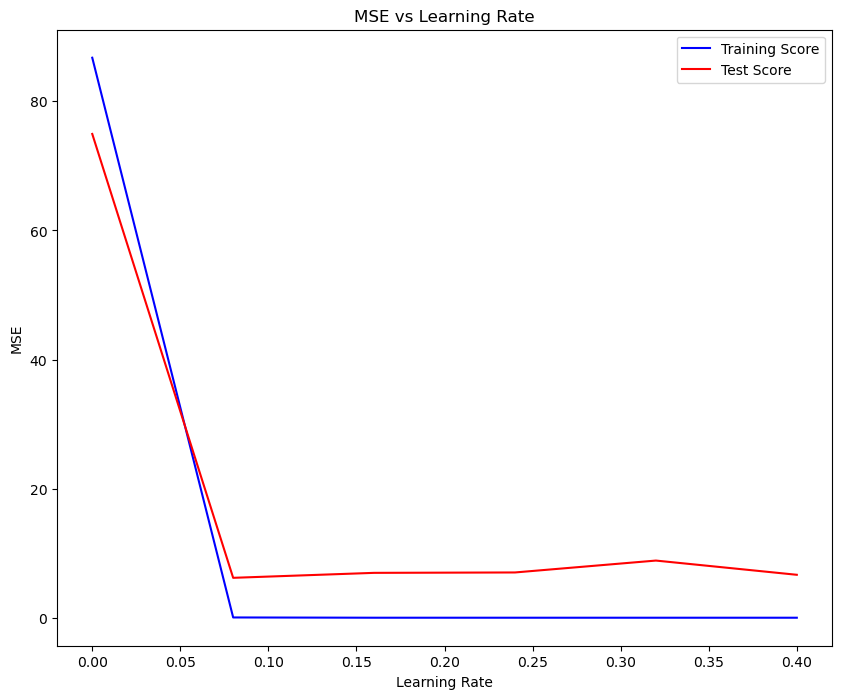

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
i = 0

lr_test_score = []
lr_train_score = []
lr_rsquared = []

for l in np.linspace(0.000001, 0.4, 6):
    gbr_lr = GradientBoostingRegressor(n_estimators = 800, 
                                max_depth = 3, 
                                min_samples_split = 5, 
                                learning_rate = l, 
                                loss= 'ls')
    gbr_lr.fit(X_train_std, y_train)

    y_pred_train = gbr_lr.predict(X_train_std)
    y_pred_test = gbr_lr.predict(X_test_std)

    gbr_mse_train_lr = mean_squared_error(y_pred_train, y_train)
    gbr_mse_test_lr = mean_squared_error(y_pred_test, y_test)
    gbr_r2_lr = gbr_lr.score(X_test_std, y_test)

    lr_train_score.append(gbr_mse_train_lr)
    lr_test_score.append(gbr_mse_test_lr)
    lr_rsquared.append(gbr_r2_lr)
    
    train_scores = gbr.train_score_
    test_scores = np.zeros((800,), dtype=np.float64)
    for k, y_pred in enumerate(gbr.staged_predict(X_test_std)):
        test_scores[k] = gbr.loss_(y_test, y_pred)
    
axs.plot(np.linspace(0.000001, 0.4, 6), lr_train_score, color='blue', label = 'Training Score')
axs.plot(np.linspace(0.000001, 0.4, 6), lr_test_score, color='red', label = 'Test Score')

axs.set_xlabel('Learning Rate')
axs.set_ylabel('MSE')
axs.set_title('MSE vs Learning Rate')
axs.legend()
axs.grid(False)
i += 1

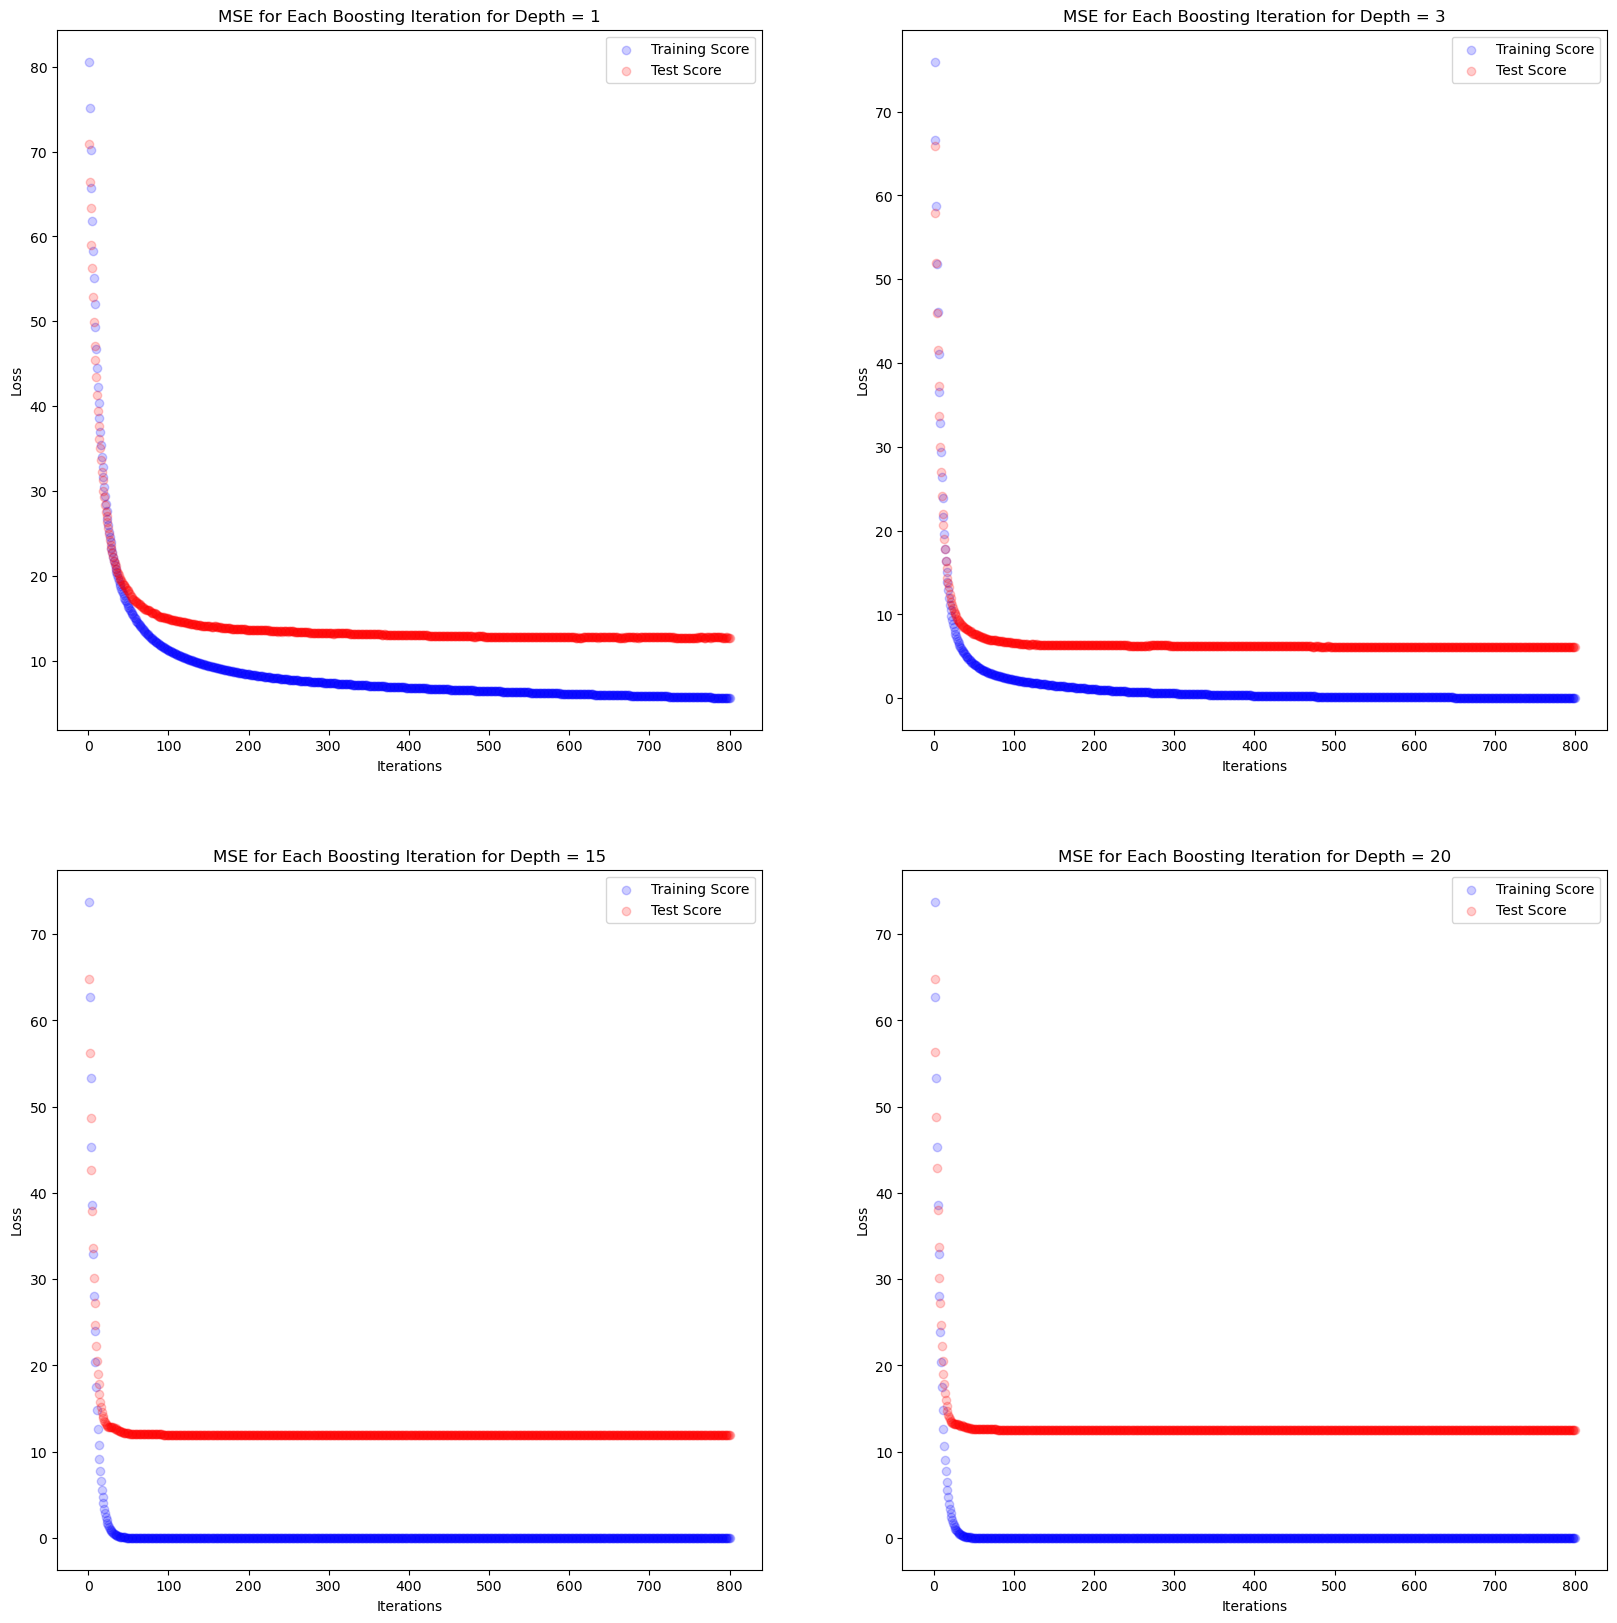

In [74]:
# your code here
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
axs = axs.ravel()

i = 0
for j in [1,3,15,20]:
    gbr_d = GradientBoostingRegressor(n_estimators = 800, 
                                max_depth = j, 
                                min_samples_split = 5, 
                                learning_rate = 0.08, 
                                loss= 'ls', random_state = 42)
    gbr_d.fit(X_train_std, y_train)

    y_pred_train_d = gbr_d.predict(X_train_std)
    y_pred_test_d = gbr_d.predict(X_test_std)

    gbr_mse_traing_d = mean_squared_error(y_pred_train_d, y_train)
    gbr_mse_test_d = mean_squared_error(y_pred_test_d, y_test)
    gbr_r2_d = gbr_d.score(X_test_std, y_test)
    
    train_scores = gbr_d.train_score_
    test_scores = np.zeros((800,), dtype=np.float64)
    for k, y_pred in enumerate(gbr_d.staged_predict(X_test_std)):
        test_scores[k] = gbr_d.loss_(y_test, y_pred)
    
    axs[i].scatter(range(1,801), train_scores, alpha = 0.2, color='blue', label = 'Training Score')
    axs[i].scatter(range(1,801), test_scores, alpha = 0.2, color='red', label = 'Test Score')

    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Loss')
    axs[i].set_title('MSE for Each Boosting Iteration for Depth = '+str(j))
    axs[i].legend()
    axs[i].grid(False)
    i += 1

[2.62188365e-02 6.12427477e-04 2.61135957e-03 3.76111747e-04
 3.45421954e-02 4.25761219e-01 1.70407171e-02 7.58301716e-02
 2.24359937e-03 1.25501941e-02 3.29812416e-02 1.59225565e-02
 3.53309370e-01]


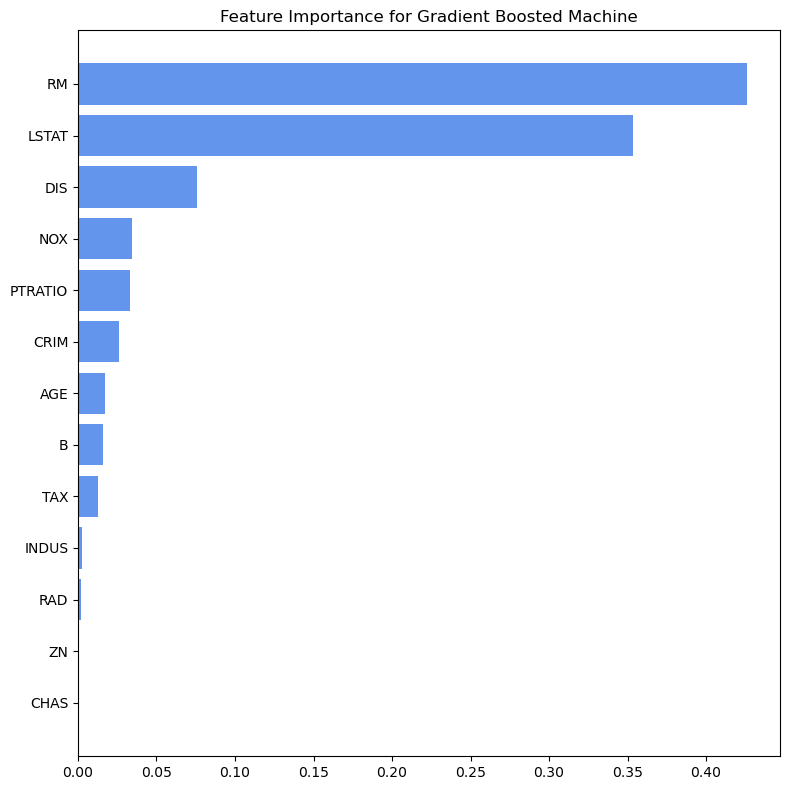

In [75]:
# Get Feature importance data using feature_importances_ attribute

feature_importance = gbr.feature_importances_
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'cornflowerblue')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance for Gradient Boosted Machine')
result = permutation_importance(gbr, X_test_std, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()


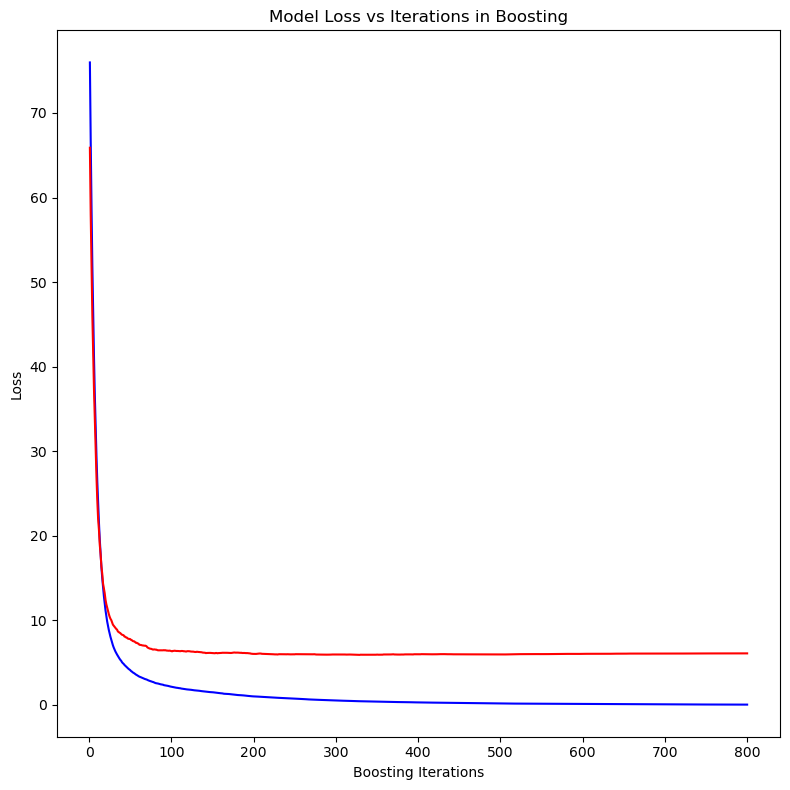

In [76]:
gbr = GradientBoostingRegressor(n_estimators = 800, 
                                max_depth = 3, 
                                learning_rate = 0.08)
gbr.fit(X_train_std, y_train)

y_pred_train = gbr.predict(X_train_std)
y_pred_test = gbr.predict(X_test_std)

gbr_mse_train = mean_squared_error(y_pred_train, y_train)
gbr_mse_test = mean_squared_error(y_pred_test, y_test)
gbr_r2 = gbr.score(X_test_std, y_test)

test_score = np.zeros((800,), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test_std)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(np.arange(800) + 1, gbr.train_score_, 'b-',
         label='Training Set Loss')
plt.plot(np.arange(800) + 1, test_score, 'r-',
         label='Test Set Loss')

plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.title('Model Loss vs Iterations in Boosting')

fig.tight_layout()
plt.show()

In [77]:
data = [{'Model': 'single depth-12  tree chosen by CV', 
         'Training MSE': best_cv_tree_train_mse, 
         'Test MSE': best_cv_tree_test_mse,
         'R-Squared': best_r_squared_dtr}, 
        {'Model': 'single overfit depth-20  tree', 
         'Training MSE': dtree_over_train_mse, 
         'Test MSE': dtree_over_test_mse,
         'R-Squared': r_squared_dtr_over}, 
        {'Model': 'bagging 55 depth-20  trees', 
         'Training MSE': bagging_mse_train, 
         'Test MSE': bagging_mse_test, 
         'R-Squared': bagging_r2}, 
        {'Model': 'random forest of 55 depth-20  trees', 
         'Training MSE': random_forest_train_mse,
         'Test MSE': random_forest_test_mse, 
         'R-Squared': random_forest_r_squared}, 
        {'Model': 'gradient boosting machine',
         'Training MSE': gbr_mse_train, 
         'Test MSE': gbr_mse_test,
         'R-Squared': gbr_r2}
       ]
# pass column names in the columns parameter 
tree_results_df = pd.DataFrame(data)
tree_results_df.head()

,Model,Training MSE,Test MSE,R-Squared
0,single depth-12 tree chosen by CV,0.039230,11.340924,0.845352
1,single overfit depth-20 tree,0.000000,23.594706,0.678256
2,bagging 55 depth-20 trees,2.108830,9.573392,0.847417
3,random forest of 55 depth-20 trees,1.811040,11.360645,0.845083
4,gradient boosting machine,0.040035,6.098024,0.916846


## Support Vector Machine

In [78]:
svr_rbf = svm.SVR(kernel='rbf', gamma=0.1)
svr_rbf.fit(X_train_std, y_train)

svr_linear = svm.SVR(kernel='linear')
svr_linear.fit(X_train_std, y_train)

SVR(kernel='linear')

In [79]:
y_pred_train = svr_rbf.predict(X_train_std)
y_pred_test = svr_rbf.predict(X_test_std)

rbf_MSE_train = mean_squared_error(y_pred_train, y_train)
rbf_MSE_test = mean_squared_error(y_pred_test, y_test)
rbf_r_2 = svr_rbf.score(X_test_std, y_test)

In [80]:
y_pred_train = svr_linear.predict(X_train_std)
y_pred_test = svr_linear.predict(X_test_std)

linear_MSE_train = mean_squared_error(y_pred_train, y_train)
linear_MSE_test = mean_squared_error(y_pred_test, y_test)
linear_r_2 = svr_linear.score(X_test_std, y_test)

In [81]:
data = [{'Model': 'SVM rbf', 
         'Training MSE': rbf_MSE_train, 
         'Test MSE': rbf_MSE_test,
         'R-Squared': rbf_r_2}, 
        {'Model': 'SVM linear', 
         'Training MSE': linear_MSE_train, 
         'Test MSE': linear_MSE_test,
         'R-Squared': linear_r_2}]
# pass column names in the columns parameter 
svm_results_df = pd.DataFrame(data)
svm_results_df.head()

,Model,Training MSE,Test MSE,R-Squared
0,SVM rbf,28.937015,27.195258,0.629158
1,SVM linear,24.636993,28.920805,0.605628


# Multilayer Preceptron

In [82]:
from sklearn.neural_network import MLPRegressor
reg= MLPRegressor(hidden_layer_sizes=(100,),activation="relu" ,random_state=1, max_iter=2000)
reg.fit(X_train_std, y_train)

y_pred_train=reg.predict(X_train_std)
y_pred_test=reg.predict(X_test_std)


mlp_MSE_train = mean_squared_error(y_pred_train, y_train)
mlp_MSE_test = mean_squared_error(y_pred_test, y_test)
mlp_r_2 = reg.score(X_test_std, y_test)

In [83]:
data = [{'Model': 'MLP', 
         'Training MSE': mlp_MSE_train, 
         'Test MSE': mlp_MSE_test,
         'R-Squared': mlp_r_2}]
# pass column names in the columns parameter 
mlp_results_df = pd.DataFrame(data)
mlp_results_df.head()

,Model,Training MSE,Test MSE,R-Squared
0,MLP,10.884547,12.749735,0.826141


In [84]:
#add layers
mlp_MSE_train_list = []
mlp_MSE_test_list = []
mlp_r_2_list = []

layers = (100,)
for i in range(10):
    reg= MLPRegressor(hidden_layer_sizes=layers,activation="relu" ,random_state=1, max_iter=2000)
    reg.fit(X_train_std, y_train)

    y_pred_train=reg.predict(X_train_std)
    y_pred_test=reg.predict(X_test_std)


    mlp_MSE_train = mean_squared_error(y_pred_train, y_train)
    mlp_MSE_test = mean_squared_error(y_pred_test, y_test)
    mlp_r_2 = reg.score(X_test_std, y_test)
    
    mlp_MSE_train_list.append(mlp_MSE_train)
    mlp_MSE_test_list.append(mlp_MSE_test)
    mlp_r_2_list.append(mlp_r_2)
    
    layers = list(layers)
    layers.append(100)
    layers = tuple(layers)

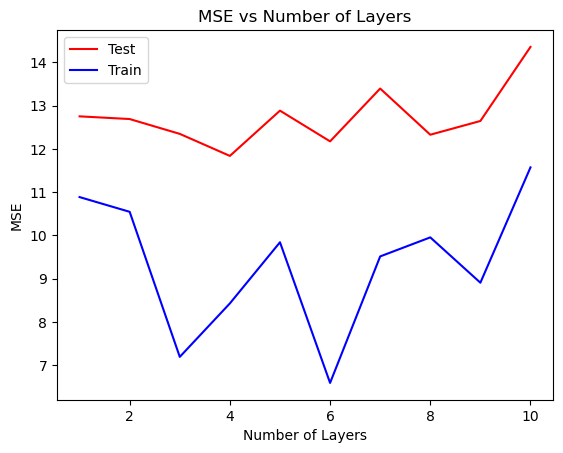

In [85]:
plt.plot(range(1,11), mlp_MSE_test_list, color = 'red', label = 'Test')
plt.plot(range(1,11), mlp_MSE_train_list, color = 'blue', label = 'Train')
plt.xlabel('Number of Layers')
plt.ylabel('MSE')
plt.title('MSE vs Number of Layers')
plt.legend()

In [86]:
from sklearn.neural_network import MLPRegressor
reg= MLPRegressor(hidden_layer_sizes=(100,100,100,100),activation="relu" ,random_state=1, max_iter=2000)
reg.fit(X_train_std, y_train)

y_pred_train=reg.predict(X_train_std)
y_pred_test=reg.predict(X_test_std)


mlp_MSE_train = mean_squared_error(y_pred_train, y_train)
mlp_MSE_test = mean_squared_error(y_pred_test, y_test)
mlp_r_2 = reg.score(X_test_std, y_test)

data = [{'Model': 'MLP', 
         'Training MSE': mlp_MSE_train, 
         'Test MSE': mlp_MSE_test,
         'R-Squared': mlp_r_2}]
# pass column names in the columns parameter 
mlp_results_df = pd.DataFrame(data)
mlp_results_df.head()

,Model,Training MSE,Test MSE,R-Squared
0,MLP,8.428066,11.83581,0.838604


## Compare the Performances of all Models

In [87]:
df_results = pd.concat([linear_results_df, pcr_results_df, tree_results_df, svm_results_df, mlp_results_df], join="inner")
df_results

,Model,Training MSE,Test MSE,R-Squared
0,Linear Regression,21.404165,23.111529,0.684845
1,Lasso Regression,23.341191,22.760518,0.689631
2,Lasso Regression with Interaction Terms,21.873995,23.239585,0.683099
0,PCA Linear Regression,21.641378,24.290650,0.668766
1,PCA Linear Regression with Interaction Terms,9.696547,12.038558,0.835839
0,single depth-12 tree chosen by CV,0.039230,11.340924,0.845352
1,single overfit depth-20 tree,0.000000,23.594706,0.678256
2,bagging 55 depth-20 trees,2.108830,9.573392,0.847417
3,random forest of 55 depth-20 trees,1.811040,11.360645,0.845083
4,gradient boosting machine,0.040035,6.098024,0.916846


Text(0.5, 1.0, 'Model vs R Squared')

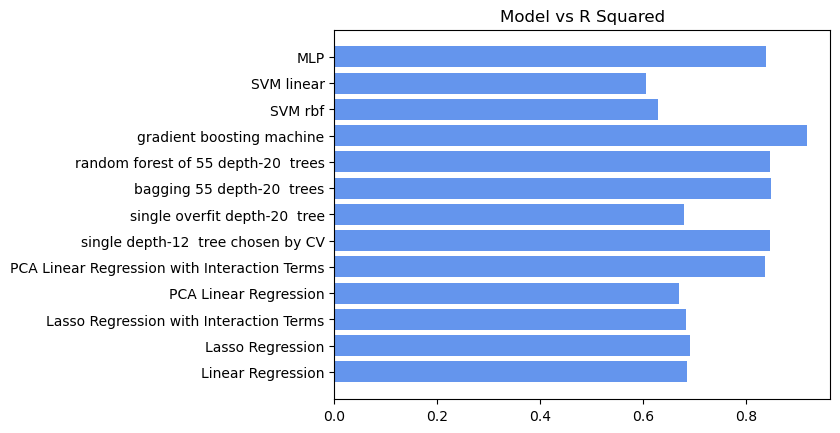

In [88]:
plt.barh(df_results.Model, df_results['R-Squared'], color = 'cornflowerblue')
plt.title('Model vs R Squared')

Text(0.5, 1.0, 'Model vs Test MSE')

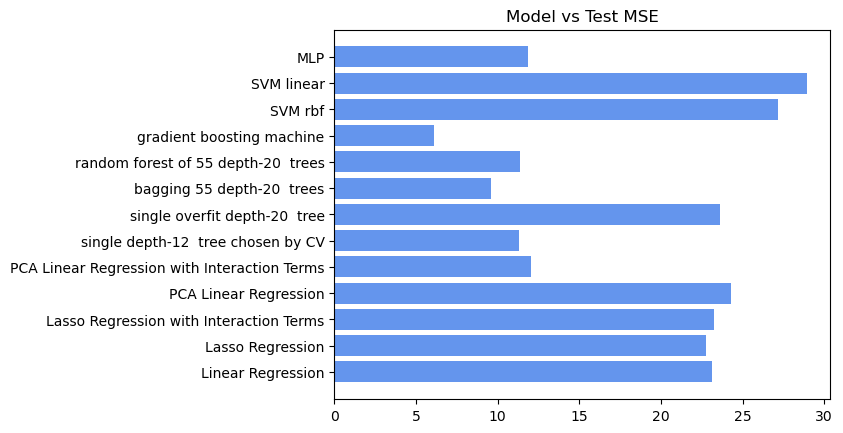

In [89]:
plt.barh(df_results.Model, df_results['Test MSE'], color = 'cornflowerblue')
plt.title('Model vs Test MSE')